In [1]:
# The following pytorch code is based on
# https://github.com/snowbbbb/code-for-Global-Convergence-of-Over-parameterized-Deep-Equilibrium-Models

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import math
import cmath
import os
import torch.nn.functional as F
import random
from torch.utils.data import TensorDataset
import torch.autograd as autograd
from torch.utils.data import ConcatDataset
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

'''
SEED = 2
torch.manual_seed(SEED)
random.seed(SEED)　　 
torch.cuda.manual_seed(SEED) 
torch.backends.cudnn.deterministic = True
'''

'\nSEED = 2\ntorch.manual_seed(SEED)\nrandom.seed(SEED)\u3000\u3000 \ntorch.cuda.manual_seed(SEED) \ntorch.backends.cudnn.deterministic = True\n'

In [66]:
root_train = '/Users/lantruong/Dataset/MNIST/'
trainTransform = transforms.Compose([transforms.Grayscale(1),
                                transforms.ToTensor()])
trainset_full = torchvision.datasets.MNIST(root_train, train = True, download = True, transform = trainTransform)

idx = (trainset_full.targets==0)
trainset_full.targets = trainset_full.targets[idx]
trainset_full.data = trainset_full.data[idx]
trainset0 = torch.utils.data.Subset(trainset_full, range(500))

trainset_full = torchvision.datasets.MNIST(root_train, train = True, download = True, transform = trainTransform)

idx = (trainset_full.targets==1)
trainset_full.targets = trainset_full.targets[idx]
trainset_full.data = trainset_full.data[idx]
trainset1 = torch.utils.data.Subset(trainset_full, range(500))

trainset=torch.utils.data.ConcatDataset([trainset0,trainset1])


In [99]:
print([trainset_full[i] for i in range(10)])

[(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.000

In [78]:
########################################################################
# Download and define the training set.

samplesize = 10000
netDepth = 2

trainloader = torch.utils.data.DataLoader(trainset, batch_size=len(trainset), shuffle=True)
batchsize=1000
dataiter = iter(trainloader)
images, labels =next(dataiter)
images=torch.flatten(images,start_dim=1)
images = F.normalize(images, p=2, dim=1)
allLabel =torch.rand(1000)
train_ids = TensorDataset(images, allLabel)
trainloader = torch.utils.data.DataLoader(dataset=train_ids, batch_size=len(train_ids), shuffle=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

output_size=1

In [79]:
def FPIter(f, x0, m=5, lam=1e-4, max_iter=50, tol=1e-2, beta=1.0):
    # Anderson acceleration for fixed point iteration.
    bsz, D = x0.shape
    X = torch.zeros(bsz, m, D, dtype=x0.dtype, device=x0.device)
    F = torch.zeros(bsz, m, D, dtype=x0.dtype, device=x0.device)
    X[:, 0], F[:, 0] = x0.view(bsz, -1), f(x0).view(bsz, -1)
    X[:, 1], F[:, 1] = F[:, 0], f(F[:, 0].view_as(x0)).view(bsz, -1)

    H = torch.zeros(bsz, m + 1, m + 1, dtype=x0.dtype, device=x0.device)
    H[:, 0, 1:] = H[:, 1:, 0] = 1
    y = torch.zeros(bsz, m + 1, 1, dtype=x0.dtype, device=x0.device)
    y[:, 0] = 1

    res = []
    for k in range(2, max_iter):
        n = min(k, m)
        G = F[:, :n] - X[:, :n]
        H[:, 1:n + 1, 1:n + 1] = torch.bmm(G, G.transpose(1, 2)) + lam * torch.eye(n, dtype=x0.dtype, device=x0.device)[
            None]
        alpha = torch.linalg.solve(H[:, :n + 1, :n + 1],y[:, :n + 1])[:, 1:n + 1, 0]  # (bsz x n)

        X[:, k % m] = beta * (alpha[:, None] @ F[:, :n])[:, 0] + (1 - beta) * (alpha[:, None] @ X[:, :n])[:, 0]
        F[:, k % m] = f(X[:, k % m].view_as(x0)).view(bsz, -1)
        res.append((F[:, k % m] - X[:, k % m]).norm().item() / (1e-5 + F[:, k % m].norm().item()))
        if (res[-1] < tol):
            break
    return X[:, k % m].view_as(x0), res

In [80]:
class Net(nn.Module):
    def __init__(self, width,Wstd):
        super(Net, self).__init__()
        self.wmatrix=nn.Linear(width,width)
        torch.nn.init.normal_(self.wmatrix.weight, mean=0, std=Wstd)   #nn.normal的参数中std是标准差 正态分布N(u,d^2)  方差为d^2,标准差为d，


    def forward(self, z, x):
        y = F.sigmoid(self.wmatrix(z)+x) * (math.sqrt(1 / width))
        return y

In [81]:
class DEQFixedPoint(nn.Module):
    def __init__(self, f, solver, **kwargs):
        super().__init__()
        self.f = f
        self.solver = solver
        self.kwargs = kwargs

    def forward(self, x):
        # compute forward pass and re-engage autograd tape
        with torch.no_grad():
            z, self.forward_res = self.solver(lambda z: self.f(z, x), torch.zeros_like(x), **self.kwargs)
        z = self.f(z, x)

        # set up Jacobian vector product (without additional forward calls)
        z0 = z.clone().detach().requires_grad_()
        f0 = self.f(z0, x)

        def backward_hook(grad):
            g, self.backward_res = self.solver(lambda y: autograd.grad(f0, z0, y, retain_graph=True)[0] + grad,
                                               grad, **self.kwargs)
            return g

        z.register_hook(backward_hook)
        return z

In [82]:
def get_jacobian(model, x):
    nc = x.size()[0]
    ny = x.size()[2]
    nx = x.size()[1]
    noutputs = 10
    x = x.reshape(nc * nx * ny)
    x = x.repeat(noutputs, 1)
    x.requires_grad_(True)
    y = model(x.reshape(noutputs, nc, nx, ny))
    y.backward(torch.eye(noutputs).to(device))
    return x.grad.data

In [83]:
def setup_and_train(epochs, lr, width, Wstd):
    ######################################################################
    # Model setup
    f = Net(width, Wstd)
    linear_input = nn.Linear(1 *  28 * 28, width)
    linear_output = nn.Linear(width, output_size)
    torch.nn.init.normal_(linear_input.weight, mean=0, std=1)
    torch.nn.init.normal_(linear_output.weight, mean=0, std=1)
    model = nn.Sequential(linear_input,
                          DEQFixedPoint(f, FPIter, tol=1e-2, max_iter=25),
                          linear_output).to(device)
    model.to(device);
    newmodel = torch.nn.Sequential(*(list(model.children())[:-1]))
    ######################################################################
    # Define criterion and optimizer
    criterion = torch.nn.MSELoss(reduce=True, size_average=False)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.0)

  
    ###################################2###################################
    # Train the model
    model.train()
    loss_plot=[]
    
  
    for epoch in range(epochs):  # loop over the dataset multiple times
        epoch_start_time = time.time()
        running_loss = 0.0
        log_interval = 100
        train_acc = 0.0
        for batch, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            if hasattr(torch.cuda, 'empty_cache'):
               torch.cuda.empty_cache()
            outputs = model(inputs)

            outVector=newmodel(inputs)
            if width <1000:
               matrixA = torch.mm(outVector.T, outVector)
            else:
               matrixA = torch.mm(outVector, outVector.T)
            (lambdamin,lambdaVec) = torch.linalg.eig(matrixA)
            print("lambda_min", lambdamin[-1])
            WMatrix = f.wmatrix.weight * (math.sqrt(1 / width))
            matrixA = torch.mm(WMatrix.T, WMatrix)
            (singmax, singularVec) = torch.linalg.eig(matrixA)
            print("singular_max", torch.sqrt(singmax[0]))

            loss= criterion(outputs.reshape(labels.shape),labels.float())
            if hasattr(torch.cuda, 'empty_cache'): 
               torch.cuda.empty_cache()
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()
        cur_loss = running_loss / (batch + 1)
        print('| end of epoch {:3d} | time / epoch {:5.2f}s | loss {:5.2f} '.format
              (epoch + 1, (time.time() - epoch_start_time), cur_loss))
        loss_plot.append(cur_loss)  
        running_loss = 0.
    return loss_plot   

In [85]:
epochs =2000 #2000      # Number of epochs
Wstd = 0.4
lr = 0.0001
width=4000


loss_plot4000=setup_and_train(epochs, lr, 4000, Wstd)

lambda_min tensor(3.4607e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   1 | time / epoch 17.95s | loss 2257.81 
lambda_min tensor(4.8083e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   2 | time / epoch 17.58s | loss 1234.11 
lambda_min tensor(2.8409e-05-3.6738e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   3 | time / epoch 17.67s | loss 699.69 
lambda_min tensor(3.7417e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   4 | time / epoch 17.71s | loss 420.68 
lambda_min tensor(5.3771e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   5 | time / epoch 17.88s | loss 275.00 
lambda_min tensor(3.7010e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| 

lambda_min tensor(2.7982e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  48 | time / epoch 17.59s | loss 113.73 
lambda_min tensor(4.1928e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  49 | time / epoch 17.84s | loss 113.68 
lambda_min tensor(3.2216e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  50 | time / epoch 17.55s | loss 113.64 
lambda_min tensor(4.0670e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  51 | time / epoch 17.71s | loss 113.59 
lambda_min tensor(4.4282e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  52 | time / epoch 17.85s | loss 113.55 
lambda_min tensor(3.2651e-05-3.6421e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| en

lambda_min tensor(7.3967e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  95 | time / epoch 17.78s | loss 111.81 
lambda_min tensor(3.8885e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  96 | time / epoch 17.55s | loss 111.77 
lambda_min tensor(2.9074e-05-1.4050e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  97 | time / epoch 17.64s | loss 111.73 
lambda_min tensor(3.7592e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  98 | time / epoch 17.71s | loss 111.70 
lambda_min tensor(2.7963e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  99 | time / epoch 17.63s | loss 111.66 
lambda_min tensor(6.2043e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| en

singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 142 | time / epoch 17.70s | loss 110.27 
lambda_min tensor(4.0014e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 143 | time / epoch 17.69s | loss 110.24 
lambda_min tensor(3.1262e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 144 | time / epoch 17.59s | loss 110.21 
lambda_min tensor(3.6971e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 145 | time / epoch 17.87s | loss 110.19 
lambda_min tensor(4.0408e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 146 | time / epoch 17.71s | loss 110.16 
lambda_min tensor(3.8657e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 147 | time / epoch 17.71s | loss 110.13 
lambda_min tensor

lambda_min tensor(3.9944e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 190 | time / epoch 17.79s | loss 109.01 
lambda_min tensor(4.0459e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 191 | time / epoch 17.71s | loss 108.98 
lambda_min tensor(4.8556e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 192 | time / epoch 17.72s | loss 108.96 
lambda_min tensor(6.4545e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 193 | time / epoch 17.64s | loss 108.94 
lambda_min tensor(3.6833e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 194 | time / epoch 17.82s | loss 108.91 
lambda_min tensor(2.8030e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epo

lambda_min tensor(4.4354e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 237 | time / epoch 17.97s | loss 107.99 
lambda_min tensor(3.5288e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 238 | time / epoch 17.72s | loss 107.97 
lambda_min tensor(3.9332e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 239 | time / epoch 17.53s | loss 107.95 
lambda_min tensor(3.2673e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 240 | time / epoch 17.89s | loss 107.93 
lambda_min tensor(4.4253e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 241 | time / epoch 17.78s | loss 107.91 
lambda_min tensor(3.0515e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epo

lambda_min tensor(2.8735e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 284 | time / epoch 17.53s | loss 107.14 
lambda_min tensor(3.0862e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 285 | time / epoch 17.81s | loss 107.12 
lambda_min tensor(3.2579e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 286 | time / epoch 17.70s | loss 107.11 
lambda_min tensor(3.5270e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 287 | time / epoch 17.52s | loss 107.09 
lambda_min tensor(6.2223e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 288 | time / epoch 17.72s | loss 107.07 
lambda_min tensor(3.6510e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epo

singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 331 | time / epoch 17.57s | loss 106.42 
lambda_min tensor(5.4991e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 332 | time / epoch 17.96s | loss 106.40 
lambda_min tensor(2.8971e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 333 | time / epoch 17.91s | loss 106.39 
lambda_min tensor(2.8008e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 334 | time / epoch 17.60s | loss 106.38 
lambda_min tensor(3.3272e-05-6.4407e-09j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 335 | time / epoch 17.82s | loss 106.36 
lambda_min tensor(3.0405e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 336 | time / epoch 17.52s | loss 106.35 
lambda_mi

singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 378 | time / epoch 17.70s | loss 105.80 
lambda_min tensor(3.4881e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 379 | time / epoch 18.02s | loss 105.78 
lambda_min tensor(4.0943e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 380 | time / epoch 17.71s | loss 105.77 
lambda_min tensor(3.8654e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 381 | time / epoch 17.68s | loss 105.76 
lambda_min tensor(3.2741e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 382 | time / epoch 17.95s | loss 105.75 
lambda_min tensor(3.3757e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 383 | time / epoch 17.75s | loss 105.73 
lambda_min tensor

lambda_min tensor(4.3938e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 426 | time / epoch 17.68s | loss 105.24 
lambda_min tensor(5.9383e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 427 | time / epoch 17.96s | loss 105.23 
lambda_min tensor(3.7787e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 428 | time / epoch 17.70s | loss 105.22 
lambda_min tensor(2.8819e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 429 | time / epoch 17.71s | loss 105.21 
lambda_min tensor(4.4988e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 430 | time / epoch 17.60s | loss 105.20 
lambda_min tensor(3.8944e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epo

singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 473 | time / epoch 17.65s | loss 104.75 
lambda_min tensor(3.1498e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 474 | time / epoch 17.84s | loss 104.74 
lambda_min tensor(3.1522e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 475 | time / epoch 18.01s | loss 104.73 
lambda_min tensor(3.3827e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 476 | time / epoch 17.73s | loss 104.73 
lambda_min tensor(4.0410e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 477 | time / epoch 18.09s | loss 104.72 
lambda_min tensor(3.1703e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 478 | time / epoch 18.02s | loss 104.71 
lambda_min tensor

singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 520 | time / epoch 17.60s | loss 104.32 
lambda_min tensor(2.9207e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 521 | time / epoch 17.63s | loss 104.31 
lambda_min tensor(3.8214e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 522 | time / epoch 17.74s | loss 104.30 
lambda_min tensor(3.1745e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 523 | time / epoch 17.72s | loss 104.29 
lambda_min tensor(3.5772e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 524 | time / epoch 17.67s | loss 104.28 
lambda_min tensor(3.9601e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 525 | time / epoch 17.71s | loss 104.27 
lambda_min tensor

lambda_min tensor(3.7621e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 568 | time / epoch 17.65s | loss 103.91 
lambda_min tensor(4.3011e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 569 | time / epoch 17.76s | loss 103.90 
lambda_min tensor(3.9664e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 570 | time / epoch 17.52s | loss 103.90 
lambda_min tensor(3.9541e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 571 | time / epoch 17.85s | loss 103.89 
lambda_min tensor(3.1652e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 572 | time / epoch 17.45s | loss 103.88 
lambda_min tensor(3.2020e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epo

lambda_min tensor(4.6620e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 615 | time / epoch 17.86s | loss 103.55 
lambda_min tensor(4.2704e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 616 | time / epoch 17.83s | loss 103.54 
lambda_min tensor(7.0803e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 617 | time / epoch 17.67s | loss 103.53 
lambda_min tensor(3.2958e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 618 | time / epoch 17.59s | loss 103.52 
lambda_min tensor(7.1878e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 619 | time / epoch 18.10s | loss 103.52 
lambda_min tensor(3.8156e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epo

lambda_min tensor(3.1365e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 662 | time / epoch 17.61s | loss 103.21 
lambda_min tensor(2.6823e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 663 | time / epoch 17.72s | loss 103.20 
lambda_min tensor(2.6821e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 664 | time / epoch 17.88s | loss 103.19 
lambda_min tensor(5.2191e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 665 | time / epoch 17.66s | loss 103.19 
lambda_min tensor(3.5542e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 666 | time / epoch 17.80s | loss 103.18 
lambda_min tensor(3.4732e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epo

singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 709 | time / epoch 17.77s | loss 102.89 
lambda_min tensor(3.1997e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 710 | time / epoch 17.65s | loss 102.88 
lambda_min tensor(4.3343e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 711 | time / epoch 17.95s | loss 102.88 
lambda_min tensor(2.8545e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 712 | time / epoch 17.78s | loss 102.87 
lambda_min tensor(3.1979e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 713 | time / epoch 17.70s | loss 102.86 
lambda_min tensor(3.1944e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 714 | time / epoch 17.69s | loss 102.86 
lambda_min tensor

lambda_min tensor(3.9472e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 757 | time / epoch 17.78s | loss 102.58 
lambda_min tensor(2.8476e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 758 | time / epoch 17.72s | loss 102.58 
lambda_min tensor(8.9352e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 759 | time / epoch 17.57s | loss 102.57 
lambda_min tensor(3.6342e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 760 | time / epoch 17.84s | loss 102.56 
lambda_min tensor(3.9711e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 761 | time / epoch 17.71s | loss 102.56 
lambda_min tensor(4.9842e-05-2.6717e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| en

singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 804 | time / epoch 17.61s | loss 102.30 
lambda_min tensor(3.8047e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 805 | time / epoch 17.77s | loss 102.29 
lambda_min tensor(2.9320e-05-3.3998e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 806 | time / epoch 17.79s | loss 102.29 
lambda_min tensor(4.4704e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 807 | time / epoch 17.82s | loss 102.28 
lambda_min tensor(4.0512e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 808 | time / epoch 17.55s | loss 102.28 
lambda_min tensor(9.9286e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 809 | time / epoch 17.65s | loss 102.27 
lambda_mi

lambda_min tensor(3.4645e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 852 | time / epoch 17.71s | loss 102.02 
lambda_min tensor(3.7547e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 853 | time / epoch 17.85s | loss 102.02 
lambda_min tensor(3.4886e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 854 | time / epoch 17.69s | loss 102.01 
lambda_min tensor(3.9207e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 855 | time / epoch 17.74s | loss 102.01 
lambda_min tensor(3.8314e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 856 | time / epoch 17.73s | loss 102.00 
lambda_min tensor(3.2628e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epo

lambda_min tensor(3.7737e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 899 | time / epoch 17.96s | loss 101.77 
lambda_min tensor(2.7820e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 900 | time / epoch 17.62s | loss 101.76 
lambda_min tensor(3.9966e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 901 | time / epoch 17.83s | loss 101.76 
lambda_min tensor(4.1662e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 902 | time / epoch 17.89s | loss 101.75 
lambda_min tensor(6.0611e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 903 | time / epoch 17.59s | loss 101.74 
lambda_min tensor(3.5831e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epo

lambda_min tensor(3.1234e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 946 | time / epoch 18.03s | loss 101.52 
lambda_min tensor(2.9000e-05-7.2299e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 947 | time / epoch 17.79s | loss 101.51 
lambda_min tensor(3.9999e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 948 | time / epoch 17.91s | loss 101.51 
lambda_min tensor(3.6245e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 949 | time / epoch 17.96s | loss 101.50 
lambda_min tensor(5.8867e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 950 | time / epoch 17.80s | loss 101.50 
lambda_min tensor(2.7049e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| en

lambda_min tensor(3.0114e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 993 | time / epoch 18.02s | loss 101.28 
lambda_min tensor(3.6781e-05-2.3398e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 994 | time / epoch 17.83s | loss 101.28 
lambda_min tensor(3.7077e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 995 | time / epoch 17.88s | loss 101.27 
lambda_min tensor(3.9950e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 996 | time / epoch 17.70s | loss 101.27 
lambda_min tensor(3.6155e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 997 | time / epoch 17.65s | loss 101.26 
lambda_min tensor(4.1800e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| en

lambda_min tensor(5.9962e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1040 | time / epoch 17.61s | loss 101.05 
lambda_min tensor(3.8986e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1041 | time / epoch 17.64s | loss 101.05 
lambda_min tensor(3.5464e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1042 | time / epoch 17.68s | loss 101.04 
lambda_min tensor(3.6120e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1043 | time / epoch 17.75s | loss 101.04 
lambda_min tensor(3.3166e-05-3.0851e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1044 | time / epoch 19.12s | loss 101.03 
lambda_min tensor(4.2805e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)

lambda_min tensor(3.1067e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1087 | time / epoch 17.95s | loss 100.83 
lambda_min tensor(4.6383e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1088 | time / epoch 18.01s | loss 100.83 
lambda_min tensor(3.8123e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1089 | time / epoch 17.59s | loss 100.82 
lambda_min tensor(3.0390e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1090 | time / epoch 17.65s | loss 100.82 
lambda_min tensor(3.8772e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1091 | time / epoch 17.90s | loss 100.81 
lambda_min tensor(3.2011e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end o

lambda_min tensor(4.2156e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1134 | time / epoch 17.86s | loss 100.62 
lambda_min tensor(4.5407e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1135 | time / epoch 17.71s | loss 100.61 
lambda_min tensor(9.4602e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1136 | time / epoch 17.62s | loss 100.61 
lambda_min tensor(4.3820e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1137 | time / epoch 17.84s | loss 100.60 
lambda_min tensor(3.8815e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1138 | time / epoch 17.57s | loss 100.60 
lambda_min tensor(2.7740e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end o

lambda_min tensor(4.0942e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1181 | time / epoch 17.90s | loss 100.41 
lambda_min tensor(3.1678e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1182 | time / epoch 17.83s | loss 100.41 
lambda_min tensor(2.9200e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1183 | time / epoch 17.67s | loss 100.40 
lambda_min tensor(3.5022e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1184 | time / epoch 18.01s | loss 100.40 
lambda_min tensor(4.4405e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1185 | time / epoch 17.51s | loss 100.39 
lambda_min tensor(4.0324e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7956+0.j, grad_fn=<SqrtBackward0>)
| end o

lambda_min tensor(3.7554e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1228 | time / epoch 17.69s | loss 100.21 
lambda_min tensor(3.8635e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1229 | time / epoch 17.90s | loss 100.20 
lambda_min tensor(3.4184e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1230 | time / epoch 17.74s | loss 100.20 
lambda_min tensor(3.2986e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1231 | time / epoch 17.89s | loss 100.20 
lambda_min tensor(3.5554e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1232 | time / epoch 17.62s | loss 100.19 
lambda_min tensor(3.6579e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end o

lambda_min tensor(4.5476e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1275 | time / epoch 17.92s | loss 100.01 
lambda_min tensor(3.4457e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1276 | time / epoch 18.15s | loss 100.01 
lambda_min tensor(3.2810e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1277 | time / epoch 17.96s | loss 100.00 
lambda_min tensor(3.4211e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1278 | time / epoch 18.10s | loss 100.00 
lambda_min tensor(5.3139e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1279 | time / epoch 18.15s | loss 100.00 
lambda_min tensor(3.7463e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end o

singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1322 | time / epoch 17.80s | loss 99.82 
lambda_min tensor(3.9548e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1323 | time / epoch 17.74s | loss 99.82 
lambda_min tensor(3.4049e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1324 | time / epoch 17.81s | loss 99.81 
lambda_min tensor(4.0825e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1325 | time / epoch 17.63s | loss 99.81 
lambda_min tensor(4.5903e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1326 | time / epoch 17.91s | loss 99.81 
lambda_min tensor(3.9985e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1327 | time / epoch 17.85s | loss 99.80 
lambda_min tensor

lambda_min tensor(3.3796e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1370 | time / epoch 17.63s | loss 99.63 
lambda_min tensor(3.5291e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1371 | time / epoch 17.84s | loss 99.63 
lambda_min tensor(3.4204e-05-3.3924e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1372 | time / epoch 17.61s | loss 99.62 
lambda_min tensor(2.8034e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1373 | time / epoch 17.94s | loss 99.62 
lambda_min tensor(4.4248e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1374 | time / epoch 17.72s | loss 99.62 
lambda_min tensor(3.3380e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| en

lambda_min tensor(4.1199e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1417 | time / epoch 17.64s | loss 99.45 
lambda_min tensor(7.3533e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1418 | time / epoch 17.60s | loss 99.45 
lambda_min tensor(3.5855e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1419 | time / epoch 17.84s | loss 99.44 
lambda_min tensor(3.1964e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1420 | time / epoch 17.73s | loss 99.44 
lambda_min tensor(2.8255e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1421 | time / epoch 17.85s | loss 99.44 
lambda_min tensor(4.1825e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epo

singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1464 | time / epoch 18.08s | loss 99.28 
lambda_min tensor(3.4641e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1465 | time / epoch 18.08s | loss 99.27 
lambda_min tensor(3.7384e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1466 | time / epoch 17.72s | loss 99.27 
lambda_min tensor(3.3801e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1467 | time / epoch 17.65s | loss 99.26 
lambda_min tensor(3.4262e-05-5.0757e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1468 | time / epoch 17.72s | loss 99.26 
lambda_min tensor(5.8443e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1469 | time / epoch 17.97s | loss 99.26 
lambda_mi

singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1511 | time / epoch 17.56s | loss 99.10 
lambda_min tensor(2.8630e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1512 | time / epoch 17.67s | loss 99.10 
lambda_min tensor(2.9920e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1513 | time / epoch 17.82s | loss 99.10 
lambda_min tensor(2.9919e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1514 | time / epoch 17.74s | loss 99.09 
lambda_min tensor(4.5782e-05-1.8154e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1515 | time / epoch 17.64s | loss 99.09 
lambda_min tensor(3.8633e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1516 | time / epoch 17.87s | loss 99.09 
lambda_mi

lambda_min tensor(3.3074e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1559 | time / epoch 17.59s | loss 98.93 
lambda_min tensor(3.2204e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1560 | time / epoch 17.59s | loss 98.93 
lambda_min tensor(3.3608e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1561 | time / epoch 17.69s | loss 98.92 
lambda_min tensor(3.3571e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1562 | time / epoch 17.70s | loss 98.92 
lambda_min tensor(3.0653e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1563 | time / epoch 17.87s | loss 98.92 
lambda_min tensor(3.7572e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epo

singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1606 | time / epoch 17.74s | loss 98.77 
lambda_min tensor(4.8023e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1607 | time / epoch 17.80s | loss 98.76 
lambda_min tensor(3.1594e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1608 | time / epoch 17.81s | loss 98.76 
lambda_min tensor(3.8125e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1609 | time / epoch 17.80s | loss 98.76 
lambda_min tensor(3.7972e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1610 | time / epoch 17.63s | loss 98.75 
lambda_min tensor(3.6930e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1611 | time / epoch 17.91s | loss 98.75 
lambda_min tensor

singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1653 | time / epoch 17.76s | loss 98.61 
lambda_min tensor(4.1348e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1654 | time / epoch 17.78s | loss 98.60 
lambda_min tensor(2.8589e-05-4.8392e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1655 | time / epoch 17.69s | loss 98.60 
lambda_min tensor(3.7135e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1656 | time / epoch 17.64s | loss 98.60 
lambda_min tensor(3.1505e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1657 | time / epoch 17.73s | loss 98.59 
lambda_min tensor(3.2012e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7956+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1658 | time / epoch 17.88s | loss 98.59 
lambda_mi

singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1700 | time / epoch 17.95s | loss 98.45 
lambda_min tensor(3.1670e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1701 | time / epoch 17.84s | loss 98.44 
lambda_min tensor(2.7718e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1702 | time / epoch 17.69s | loss 98.44 
lambda_min tensor(3.3633e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1703 | time / epoch 17.66s | loss 98.44 
lambda_min tensor(3.4810e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1704 | time / epoch 17.79s | loss 98.43 
lambda_min tensor(3.2822e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1705 | time / epoch 17.69s | loss 98.43 
lambda_min tensor

lambda_min tensor(3.3279e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1748 | time / epoch 17.85s | loss 98.29 
lambda_min tensor(3.1995e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1749 | time / epoch 17.74s | loss 98.29 
lambda_min tensor(3.2884e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1750 | time / epoch 17.92s | loss 98.28 
lambda_min tensor(3.8664e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1751 | time / epoch 17.78s | loss 98.28 
lambda_min tensor(3.5409e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1752 | time / epoch 17.77s | loss 98.28 
lambda_min tensor(3.4246e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epo

lambda_min tensor(3.6280e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1795 | time / epoch 17.79s | loss 98.14 
lambda_min tensor(4.5048e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1796 | time / epoch 17.76s | loss 98.14 
lambda_min tensor(3.1798e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1797 | time / epoch 17.87s | loss 98.13 
lambda_min tensor(4.1614e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1798 | time / epoch 18.07s | loss 98.13 
lambda_min tensor(3.3768e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1799 | time / epoch 17.77s | loss 98.13 
lambda_min tensor(3.4870e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epo

singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1842 | time / epoch 17.65s | loss 97.99 
lambda_min tensor(3.6716e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1843 | time / epoch 17.73s | loss 97.99 
lambda_min tensor(3.8633e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1844 | time / epoch 17.63s | loss 97.99 
lambda_min tensor(3.4308e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1845 | time / epoch 17.77s | loss 97.98 
lambda_min tensor(3.0064e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1846 | time / epoch 17.86s | loss 97.98 
lambda_min tensor(3.2456e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1847 | time / epoch 17.76s | loss 97.98 
lambda_min tensor

lambda_min tensor(5.2311e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1890 | time / epoch 17.70s | loss 97.84 
lambda_min tensor(3.9176e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1891 | time / epoch 17.94s | loss 97.84 
lambda_min tensor(3.8269e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1892 | time / epoch 17.93s | loss 97.84 
lambda_min tensor(3.8300e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1893 | time / epoch 643.14s | loss 97.83 
lambda_min tensor(3.0015e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1894 | time / epoch 17.92s | loss 97.83 
lambda_min tensor(3.7993e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of ep

lambda_min tensor(3.2518e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1937 | time / epoch 18.01s | loss 97.70 
lambda_min tensor(3.1606e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1938 | time / epoch 17.59s | loss 97.70 
lambda_min tensor(3.4440e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1939 | time / epoch 18.09s | loss 97.69 
lambda_min tensor(4.5134e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1940 | time / epoch 18.03s | loss 97.69 
lambda_min tensor(3.0375e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1941 | time / epoch 17.88s | loss 97.69 
lambda_min tensor(3.3141e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epo

singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1984 | time / epoch 17.77s | loss 97.56 
lambda_min tensor(3.7611e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1985 | time / epoch 17.98s | loss 97.56 
lambda_min tensor(3.6805e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1986 | time / epoch 17.86s | loss 97.56 
lambda_min tensor(3.7009e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1987 | time / epoch 17.81s | loss 97.55 
lambda_min tensor(3.2228e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1988 | time / epoch 17.73s | loss 97.55 
lambda_min tensor(3.0457e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7957+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1989 | time / epoch 17.87s | loss 97.55 
lambda_min tensor

In [87]:
epochs =2000 #2000      # Number of epochs
Wstd = 0.4
lr = 0.0001
width=5000

loss_plot5000=setup_and_train(epochs, lr, 5000, Wstd)

/opt/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


lambda_min tensor(4.3484e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   1 | time / epoch 33.87s | loss 116.69 
lambda_min tensor(4.6574e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   2 | time / epoch 34.21s | loss 111.03 
lambda_min tensor(3.5314e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   3 | time / epoch 35.56s | loss 108.06 
lambda_min tensor(3.5653e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   4 | time / epoch 34.24s | loss 106.50 
lambda_min tensor(4.7622e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   5 | time / epoch 33.53s | loss 105.67 
lambda_min tensor(4.0400e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epo

lambda_min tensor(4.7833e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  48 | time / epoch 34.24s | loss 103.95 
lambda_min tensor(3.5025e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  49 | time / epoch 33.90s | loss 103.93 
lambda_min tensor(4.3040e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  50 | time / epoch 34.77s | loss 103.91 
lambda_min tensor(3.0297e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  51 | time / epoch 34.67s | loss 103.90 
lambda_min tensor(4.0840e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  52 | time / epoch 35.02s | loss 103.88 
lambda_min tensor(5.2215e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epo

singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  95 | time / epoch 34.21s | loss 103.19 
lambda_min tensor(4.1733e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  96 | time / epoch 34.05s | loss 103.17 
lambda_min tensor(4.1254e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  97 | time / epoch 33.90s | loss 103.16 
lambda_min tensor(4.1972e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  98 | time / epoch 34.19s | loss 103.14 
lambda_min tensor(4.2984e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  99 | time / epoch 34.33s | loss 103.13 
lambda_min tensor(4.1699e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 100 | time / epoch 34.18s | loss 103.11 
lambda_min tensor

singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 142 | time / epoch 34.06s | loss 102.55 
lambda_min tensor(3.7772e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 143 | time / epoch 34.25s | loss 102.53 
lambda_min tensor(3.0816e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 144 | time / epoch 34.33s | loss 102.52 
lambda_min tensor(3.9967e-05-5.5783e-09j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 145 | time / epoch 34.33s | loss 102.51 
lambda_min tensor(3.7624e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 146 | time / epoch 34.13s | loss 102.50 
lambda_min tensor(1.8336e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 147 | time / epoch 34.33s | loss 102.48 
lambda_mi

lambda_min tensor(6.9965e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 190 | time / epoch 34.22s | loss 101.99 
lambda_min tensor(3.5552e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 191 | time / epoch 34.10s | loss 101.98 
lambda_min tensor(2.7438e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 192 | time / epoch 34.00s | loss 101.97 
lambda_min tensor(3.6988e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 193 | time / epoch 33.92s | loss 101.96 
lambda_min tensor(4.4392e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 194 | time / epoch 33.90s | loss 101.95 
lambda_min tensor(3.4255e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epo

lambda_min tensor(3.4018e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 237 | time / epoch 33.72s | loss 101.52 
lambda_min tensor(5.1557e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 238 | time / epoch 34.19s | loss 101.51 
lambda_min tensor(3.5372e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 239 | time / epoch 34.73s | loss 101.50 
lambda_min tensor(3.6492e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 240 | time / epoch 34.07s | loss 101.49 
lambda_min tensor(4.8125e-05-4.8788e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 241 | time / epoch 33.90s | loss 101.48 
lambda_min tensor(4.1710e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| en

lambda_min tensor(3.6730e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 284 | time / epoch 34.13s | loss 101.11 
lambda_min tensor(3.7075e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 285 | time / epoch 33.99s | loss 101.10 
lambda_min tensor(4.2486e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 286 | time / epoch 34.06s | loss 101.09 
lambda_min tensor(3.8705e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 287 | time / epoch 34.34s | loss 101.08 
lambda_min tensor(4.2936e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 288 | time / epoch 34.09s | loss 101.07 
lambda_min tensor(4.4326e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epo

lambda_min tensor(4.1683e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 331 | time / epoch 34.10s | loss 100.74 
lambda_min tensor(4.0306e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 332 | time / epoch 34.00s | loss 100.73 
lambda_min tensor(4.4799e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 333 | time / epoch 34.63s | loss 100.72 
lambda_min tensor(4.2329e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 334 | time / epoch 34.15s | loss 100.71 
lambda_min tensor(3.7734e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 335 | time / epoch 33.88s | loss 100.71 
lambda_min tensor(7.2525e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epo

lambda_min tensor(3.4066e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 378 | time / epoch 33.94s | loss 100.40 
lambda_min tensor(4.6053e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 379 | time / epoch 34.21s | loss 100.39 
lambda_min tensor(4.1159e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 380 | time / epoch 34.02s | loss 100.39 
lambda_min tensor(4.2149e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 381 | time / epoch 33.99s | loss 100.38 
lambda_min tensor(3.2190e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 382 | time / epoch 34.09s | loss 100.37 
lambda_min tensor(5.2208e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epo

singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 425 | time / epoch 34.29s | loss 100.09 
lambda_min tensor(4.2826e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 426 | time / epoch 33.73s | loss 100.08 
lambda_min tensor(3.8515e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 427 | time / epoch 34.36s | loss 100.08 
lambda_min tensor(2.8327e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 428 | time / epoch 33.76s | loss 100.07 
lambda_min tensor(3.3734e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 429 | time / epoch 33.82s | loss 100.07 
lambda_min tensor(4.1169e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 430 | time / epoch 34.43s | loss 100.06 
lambda_min tensor

lambda_min tensor(4.1693e-05-4.5962e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 473 | time / epoch 34.13s | loss 99.80 
lambda_min tensor(4.1880e-05-1.0355e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 474 | time / epoch 33.72s | loss 99.79 
lambda_min tensor(6.0643e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 475 | time / epoch 33.75s | loss 99.79 
lambda_min tensor(3.7158e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 476 | time / epoch 33.74s | loss 99.78 
lambda_min tensor(3.6527e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 477 | time / epoch 33.98s | loss 99.77 
lambda_min tensor(3.4347e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
|

singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 520 | time / epoch 1488.04s | loss 99.53 
lambda_min tensor(4.0599e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 521 | time / epoch 4342.23s | loss 99.53 
lambda_min tensor(4.1403e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 522 | time / epoch 4891.04s | loss 99.52 
lambda_min tensor(2.9961e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 523 | time / epoch 33.54s | loss 99.51 
lambda_min tensor(3.6986e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 524 | time / epoch 33.96s | loss 99.51 
lambda_min tensor(4.0373e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 525 | time / epoch 34.35s | loss 99.50 
lambda_min tensor

lambda_min tensor(3.8321e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 568 | time / epoch 33.67s | loss 99.27 
lambda_min tensor(5.0374e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 569 | time / epoch 33.73s | loss 99.27 
lambda_min tensor(3.6277e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 570 | time / epoch 33.86s | loss 99.26 
lambda_min tensor(3.9631e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 571 | time / epoch 34.03s | loss 99.26 
lambda_min tensor(4.3707e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 572 | time / epoch 34.16s | loss 99.25 
lambda_min tensor(4.1707e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 57

lambda_min tensor(4.7424e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 616 | time / epoch 371.53s | loss 99.03 
lambda_min tensor(3.8155e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 617 | time / epoch 34.88s | loss 99.02 
lambda_min tensor(4.1598e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 618 | time / epoch 34.50s | loss 99.02 
lambda_min tensor(5.2899e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 619 | time / epoch 34.51s | loss 99.01 
lambda_min tensor(6.7880e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 620 | time / epoch 34.06s | loss 99.01 
lambda_min tensor(4.1609e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 6

singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 663 | time / epoch 34.42s | loss 98.80 
lambda_min tensor(3.9200e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 664 | time / epoch 34.51s | loss 98.80 
lambda_min tensor(4.2274e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 665 | time / epoch 33.85s | loss 98.79 
lambda_min tensor(4.8409e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 666 | time / epoch 34.56s | loss 98.79 
lambda_min tensor(3.7774e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 667 | time / epoch 34.04s | loss 98.78 
lambda_min tensor(3.8157e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 668 | time / epoch 34.00s | loss 98.78 
lambda_min tensor(3.790

lambda_min tensor(3.6806e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 711 | time / epoch 33.88s | loss 98.58 
lambda_min tensor(5.0235e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 712 | time / epoch 34.23s | loss 98.57 
lambda_min tensor(3.2517e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 713 | time / epoch 33.77s | loss 98.57 
lambda_min tensor(3.8303e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 714 | time / epoch 33.77s | loss 98.56 
lambda_min tensor(3.7208e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 715 | time / epoch 34.02s | loss 98.56 
lambda_min tensor(3.7199e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 71

singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 758 | time / epoch 33.91s | loss 98.37 
lambda_min tensor(4.2424e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 759 | time / epoch 33.95s | loss 98.36 
lambda_min tensor(5.4053e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 760 | time / epoch 34.29s | loss 98.36 
lambda_min tensor(3.9185e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 761 | time / epoch 33.98s | loss 98.35 
lambda_min tensor(4.3860e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 762 | time / epoch 34.06s | loss 98.35 
lambda_min tensor(3.7306e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 763 | time / epoch 33.77s | loss 98.34 
lambda_min tensor(3.952

lambda_min tensor(3.3916e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 806 | time / epoch 35.38s | loss 98.16 
lambda_min tensor(7.3991e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 807 | time / epoch 34.83s | loss 98.15 
lambda_min tensor(4.4688e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 808 | time / epoch 34.37s | loss 98.15 
lambda_min tensor(3.8851e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 809 | time / epoch 33.80s | loss 98.15 
lambda_min tensor(4.5161e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 810 | time / epoch 34.26s | loss 98.14 
lambda_min tensor(3.6746e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 81

singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 853 | time / epoch 34.44s | loss 97.96 
lambda_min tensor(4.6134e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 854 | time / epoch 34.37s | loss 97.96 
lambda_min tensor(4.4238e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 855 | time / epoch 34.03s | loss 97.95 
lambda_min tensor(4.2027e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 856 | time / epoch 33.74s | loss 97.95 
lambda_min tensor(3.4509e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 857 | time / epoch 34.10s | loss 97.94 
lambda_min tensor(4.5963e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 858 | time / epoch 34.50s | loss 97.94 
lambda_min tensor(5.930

lambda_min tensor(5.0957e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 901 | time / epoch 34.06s | loss 97.77 
lambda_min tensor(3.9113e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 902 | time / epoch 33.90s | loss 97.76 
lambda_min tensor(3.8486e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 903 | time / epoch 34.34s | loss 97.76 
lambda_min tensor(4.3139e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 904 | time / epoch 33.71s | loss 97.75 
lambda_min tensor(6.1120e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 905 | time / epoch 34.30s | loss 97.75 
lambda_min tensor(3.9867e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 90

singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 948 | time / epoch 33.81s | loss 97.58 
lambda_min tensor(4.3385e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 949 | time / epoch 33.99s | loss 97.58 
lambda_min tensor(4.7529e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 950 | time / epoch 34.24s | loss 97.57 
lambda_min tensor(3.0690e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 951 | time / epoch 33.98s | loss 97.57 
lambda_min tensor(4.5801e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 952 | time / epoch 34.16s | loss 97.57 
lambda_min tensor(5.7773e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 953 | time / epoch 34.13s | loss 97.56 
lambda_min tensor(3.895

lambda_min tensor(3.9288e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 996 | time / epoch 33.88s | loss 97.40 
lambda_min tensor(4.7449e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 997 | time / epoch 34.21s | loss 97.39 
lambda_min tensor(4.4928e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 998 | time / epoch 34.26s | loss 97.39 
lambda_min tensor(3.4539e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 999 | time / epoch 243.92s | loss 97.39 
lambda_min tensor(4.3164e-05-3.6212e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1000 | time / epoch 33.65s | loss 97.38 
lambda_min tensor(3.1817e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end o

singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1043 | time / epoch 33.81s | loss 97.22 
lambda_min tensor(6.0788e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1044 | time / epoch 33.83s | loss 97.22 
lambda_min tensor(3.7678e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1045 | time / epoch 34.29s | loss 97.21 
lambda_min tensor(3.5137e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1046 | time / epoch 34.66s | loss 97.21 
lambda_min tensor(6.5930e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1047 | time / epoch 34.15s | loss 97.21 
lambda_min tensor(8.7377e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1048 | time / epoch 34.18s | loss 97.20 
lambda_min tensor

lambda_min tensor(4.2617e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1091 | time / epoch 34.12s | loss 97.05 
lambda_min tensor(3.0975e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1092 | time / epoch 33.87s | loss 97.04 
lambda_min tensor(4.4677e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1093 | time / epoch 33.66s | loss 97.04 
lambda_min tensor(4.7328e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1094 | time / epoch 33.88s | loss 97.04 
lambda_min tensor(4.9165e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1095 | time / epoch 33.79s | loss 97.03 
lambda_min tensor(6.2600e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epo

singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1138 | time / epoch 34.64s | loss 96.88 
lambda_min tensor(4.4230e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1139 | time / epoch 33.88s | loss 96.87 
lambda_min tensor(4.1229e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1140 | time / epoch 34.00s | loss 96.87 
lambda_min tensor(3.8293e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1141 | time / epoch 34.07s | loss 96.87 
lambda_min tensor(4.1712e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1142 | time / epoch 34.33s | loss 96.86 
lambda_min tensor(3.7771e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1143 | time / epoch 34.18s | loss 96.86 
lambda_min tensor

singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1185 | time / epoch 33.82s | loss 96.71 
lambda_min tensor(4.0105e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1186 | time / epoch 33.96s | loss 96.71 
lambda_min tensor(4.0967e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1187 | time / epoch 34.16s | loss 96.71 
lambda_min tensor(4.0810e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1188 | time / epoch 34.04s | loss 96.70 
lambda_min tensor(3.5390e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1189 | time / epoch 34.03s | loss 96.70 
lambda_min tensor(5.3171e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1190 | time / epoch 34.20s | loss 96.70 
lambda_min tensor

singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1232 | time / epoch 34.41s | loss 96.55 
lambda_min tensor(6.3975e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1233 | time / epoch 34.30s | loss 96.55 
lambda_min tensor(4.3949e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1234 | time / epoch 33.90s | loss 96.55 
lambda_min tensor(4.5439e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1235 | time / epoch 34.17s | loss 96.54 
lambda_min tensor(4.3256e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1236 | time / epoch 33.97s | loss 96.54 
lambda_min tensor(3.3082e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1237 | time / epoch 34.19s | loss 96.54 
lambda_min tensor

singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1279 | time / epoch 34.07s | loss 96.40 
lambda_min tensor(4.1603e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1280 | time / epoch 33.79s | loss 96.39 
lambda_min tensor(6.1343e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1281 | time / epoch 34.12s | loss 96.39 
lambda_min tensor(7.1493e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1282 | time / epoch 33.78s | loss 96.39 
lambda_min tensor(3.6663e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1283 | time / epoch 34.04s | loss 96.38 
lambda_min tensor(5.4440e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1284 | time / epoch 33.99s | loss 96.38 
lambda_min tensor

lambda_min tensor(3.3729e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1327 | time / epoch 34.13s | loss 96.24 
lambda_min tensor(4.0387e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1328 | time / epoch 33.98s | loss 96.24 
lambda_min tensor(3.8038e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1329 | time / epoch 34.32s | loss 96.23 
lambda_min tensor(4.7612e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1330 | time / epoch 33.83s | loss 96.23 
lambda_min tensor(5.8642e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1331 | time / epoch 34.58s | loss 96.23 
lambda_min tensor(3.4769e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epo

singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1374 | time / epoch 34.13s | loss 96.09 
lambda_min tensor(6.6218e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1375 | time / epoch 33.99s | loss 96.09 
lambda_min tensor(6.4453e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1376 | time / epoch 33.65s | loss 96.08 
lambda_min tensor(3.2505e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1377 | time / epoch 33.82s | loss 96.08 
lambda_min tensor(2.8836e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1378 | time / epoch 33.89s | loss 96.08 
lambda_min tensor(4.3329e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1379 | time / epoch 33.67s | loss 96.07 
lambda_min tensor

singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1421 | time / epoch 34.05s | loss 95.94 
lambda_min tensor(3.4518e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1422 | time / epoch 33.89s | loss 95.94 
lambda_min tensor(4.0472e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1423 | time / epoch 33.73s | loss 95.94 
lambda_min tensor(3.7690e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1424 | time / epoch 34.39s | loss 95.93 
lambda_min tensor(3.5703e-05-1.1090e-07j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1425 | time / epoch 33.81s | loss 95.93 
lambda_min tensor(3.6102e-05-2.5259e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1426 | time / epoch 33.86s | loss 95.93 
l

lambda_min tensor(4.6168e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1469 | time / epoch 34.19s | loss 95.79 
lambda_min tensor(5.2261e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1470 | time / epoch 33.84s | loss 95.79 
lambda_min tensor(4.0460e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1471 | time / epoch 34.00s | loss 95.79 
lambda_min tensor(4.0298e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1472 | time / epoch 34.12s | loss 95.78 
lambda_min tensor(3.6964e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1473 | time / epoch 34.27s | loss 95.78 
lambda_min tensor(4.1190e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epo

lambda_min tensor(6.0939e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1516 | time / epoch 33.76s | loss 95.65 
lambda_min tensor(3.4215e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1517 | time / epoch 33.98s | loss 95.65 
lambda_min tensor(4.3269e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1518 | time / epoch 33.93s | loss 95.65 
lambda_min tensor(3.6153e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1519 | time / epoch 33.97s | loss 95.64 
lambda_min tensor(8.1693e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1520 | time / epoch 33.96s | loss 95.64 
lambda_min tensor(3.4497e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epo

singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1563 | time / epoch 33.90s | loss 95.51 
lambda_min tensor(7.9787e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1564 | time / epoch 33.69s | loss 95.51 
lambda_min tensor(4.1940e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1565 | time / epoch 33.53s | loss 95.51 
lambda_min tensor(3.5649e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1566 | time / epoch 33.71s | loss 95.50 
lambda_min tensor(3.6505e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1567 | time / epoch 34.00s | loss 95.50 
lambda_min tensor(4.4268e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1568 | time / epoch 33.95s | loss 95.50 
lambda_min tensor

singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1610 | time / epoch 33.79s | loss 95.38 
lambda_min tensor(4.7562e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1611 | time / epoch 33.89s | loss 95.37 
lambda_min tensor(4.5758e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1612 | time / epoch 33.97s | loss 95.37 
lambda_min tensor(3.8619e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1613 | time / epoch 33.91s | loss 95.37 
lambda_min tensor(6.5145e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1614 | time / epoch 33.85s | loss 95.36 
lambda_min tensor(5.2235e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1615 | time / epoch 33.52s | loss 95.36 
lambda_min tensor

lambda_min tensor(4.7069e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1658 | time / epoch 34.26s | loss 95.24 
lambda_min tensor(3.9737e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1659 | time / epoch 33.96s | loss 95.23 
lambda_min tensor(4.9402e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1660 | time / epoch 34.34s | loss 95.23 
lambda_min tensor(3.9481e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1661 | time / epoch 34.21s | loss 95.23 
lambda_min tensor(4.3315e-05-9.5926e-09j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1662 | time / epoch 34.56s | loss 95.23 
lambda_min tensor(3.9561e-05-7.4456e-09j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward

lambda_min tensor(4.3400e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1705 | time / epoch 34.25s | loss 95.11 
lambda_min tensor(3.3328e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1706 | time / epoch 34.48s | loss 95.10 
lambda_min tensor(6.4260e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1707 | time / epoch 33.85s | loss 95.10 
lambda_min tensor(4.9581e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1708 | time / epoch 33.97s | loss 95.10 
lambda_min tensor(2.9474e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1709 | time / epoch 34.12s | loss 95.09 
lambda_min tensor(5.6401e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epo

singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1752 | time / epoch 34.05s | loss 94.98 
lambda_min tensor(5.5201e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1753 | time / epoch 34.04s | loss 94.97 
lambda_min tensor(3.5535e-05-1.4650e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1754 | time / epoch 34.64s | loss 94.97 
lambda_min tensor(3.9886e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1755 | time / epoch 34.08s | loss 94.97 
lambda_min tensor(8.2977e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1756 | time / epoch 34.31s | loss 94.96 
lambda_min tensor(5.7386e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1757 | time / epoch 33.99s | loss 94.96 
lambda_mi

singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1799 | time / epoch 34.32s | loss 94.85 
lambda_min tensor(2.7363e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1800 | time / epoch 34.11s | loss 94.84 
lambda_min tensor(4.1772e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1801 | time / epoch 34.17s | loss 94.84 
lambda_min tensor(4.6856e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1802 | time / epoch 34.20s | loss 94.84 
lambda_min tensor(4.7585e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1803 | time / epoch 34.17s | loss 94.84 
lambda_min tensor(3.3075e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1804 | time / epoch 34.03s | loss 94.83 
lambda_min tensor

lambda_min tensor(2.9980e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1847 | time / epoch 34.00s | loss 94.72 
lambda_min tensor(4.0655e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1848 | time / epoch 33.99s | loss 94.72 
lambda_min tensor(4.8082e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1849 | time / epoch 33.90s | loss 94.71 
lambda_min tensor(3.9161e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1850 | time / epoch 34.06s | loss 94.71 
lambda_min tensor(5.1413e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1851 | time / epoch 34.19s | loss 94.71 
lambda_min tensor(4.0713e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epo

singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1894 | time / epoch 34.50s | loss 94.60 
lambda_min tensor(3.6117e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1895 | time / epoch 33.83s | loss 94.59 
lambda_min tensor(6.0912e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1896 | time / epoch 34.10s | loss 94.59 
lambda_min tensor(3.8750e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1897 | time / epoch 34.75s | loss 94.59 
lambda_min tensor(3.8844e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1898 | time / epoch 33.78s | loss 94.59 
lambda_min tensor(4.6403e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1899 | time / epoch 33.96s | loss 94.58 
lambda_min tensor

singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1941 | time / epoch 33.85s | loss 94.47 
lambda_min tensor(6.0568e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1942 | time / epoch 34.03s | loss 94.47 
lambda_min tensor(3.4452e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1943 | time / epoch 34.01s | loss 94.47 
lambda_min tensor(4.5304e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1944 | time / epoch 34.18s | loss 94.47 
lambda_min tensor(3.8944e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1945 | time / epoch 34.02s | loss 94.46 
lambda_min tensor(4.3380e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1946 | time / epoch 34.01s | loss 94.46 
lambda_min tensor

singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1988 | time / epoch 34.70s | loss 94.35 
lambda_min tensor(4.0844e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1989 | time / epoch 35.07s | loss 94.35 
lambda_min tensor(4.3645e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1990 | time / epoch 33.78s | loss 94.35 
lambda_min tensor(5.4448e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1991 | time / epoch 34.01s | loss 94.35 
lambda_min tensor(5.8000e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1992 | time / epoch 33.99s | loss 94.34 
lambda_min tensor(4.2758e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1993 | time / epoch 34.25s | loss 94.34 
lambda_min tensor

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


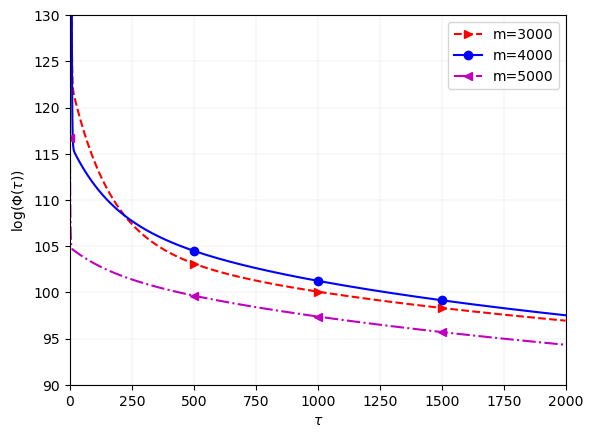

In [119]:
plt.figure(1)
plt.plot(range(epochs), loss_plot3000,'r--',marker='>',markevery=500)
plt.plot(range(epochs), loss_plot4000,'b-',marker='o',markevery=500)
plt.plot(range(epochs), loss_plot5000,'m-.',marker='<',markevery=500)
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\log(\Phi(\tau))$')
plt.legend(['m=3000','m=4000','m=5000'])
plt.axis([0,2000,90,130])
plt.savefig('code_DEM_MNIST.pdf') 
plt.savefig('code_DEM_MNIST.eps') 
plt.grid(color='k', linestyle='--', linewidth=.05)



In [106]:
class NetReLU(nn.Module):
    def __init__(self, width,Wstd):
        super(Net, self).__init__()
        self.wmatrix=nn.Linear(width,width)
        torch.nn.init.normal_(self.wmatrix.weight, mean=0, std=Wstd)   #nn.normal的参数中std是标准差 正态分布N(u,d^2)  方差为d^2,标准差为d，


    def forward(self, z, x):
        y = F.relu(self.wmatrix(z)+x) * (math.sqrt(1 / width))
        return y

In [107]:
def setup_and_train_ReLU(epochs, lr, width, Wstd):
    ######################################################################
    # Model setup
    f = NetReLU(width, Wstd)
    linear_input = nn.Linear(1 *  28 * 28, width)
    linear_output = nn.Linear(width, output_size)
    torch.nn.init.normal_(linear_input.weight, mean=0, std=1)
    torch.nn.init.normal_(linear_output.weight, mean=0, std=1)
    model = nn.Sequential(linear_input,
                          DEQFixedPoint(f, FPIter, tol=1e-2, max_iter=25),
                          linear_output).to(device)
    model.to(device);
    newmodel = torch.nn.Sequential(*(list(model.children())[:-1]))
    ######################################################################
    # Define criterion and optimizer
    criterion = torch.nn.MSELoss(reduce=True, size_average=False)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.0)

  
    ###################################2###################################
    # Train the model
    model.train()
    loss_plot=[]
    
  
    for epoch in range(epochs):  # loop over the dataset multiple times
        epoch_start_time = time.time()
        running_loss = 0.0
        log_interval = 100
        train_acc = 0.0
        for batch, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            if hasattr(torch.cuda, 'empty_cache'):
               torch.cuda.empty_cache()
            outputs = model(inputs)

            outVector=newmodel(inputs)
            if width <1000:
               matrixA = torch.mm(outVector.T, outVector)
            else:
               matrixA = torch.mm(outVector, outVector.T)
            (lambdamin,lambdaVec) = torch.linalg.eig(matrixA)
            print("lambda_min", lambdamin[-1])
            WMatrix = f.wmatrix.weight * (math.sqrt(1 / width))
            matrixA = torch.mm(WMatrix.T, WMatrix)
            (singmax, singularVec) = torch.linalg.eig(matrixA)
            print("singular_max", torch.sqrt(singmax[0]))

            loss= criterion(outputs.reshape(labels.shape),labels.float())
            if hasattr(torch.cuda, 'empty_cache'): 
               torch.cuda.empty_cache()
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()
        cur_loss = running_loss / (batch + 1)
        print('| end of epoch {:3d} | time / epoch {:5.2f}s | loss {:5.2f} '.format
              (epoch + 1, (time.time() - epoch_start_time), cur_loss))
        loss_plot.append(cur_loss)
        running_loss = 0.
    return loss_plot 

In [108]:
epochs =2000 #2000      # Number of epochs
Wstd = 0.4
lr = 0.0001
width=3000


loss_plot3000ReLU=setup_and_train(epochs, lr, 3000, Wstd)

/opt/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


lambda_min tensor(3.0342e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   1 | time / epoch  8.76s | loss 180.06 
lambda_min tensor(4.1162e-05-1.8857e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   2 | time / epoch  8.63s | loss 146.60 
lambda_min tensor(4.8004e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   3 | time / epoch  8.56s | loss 129.18 
lambda_min tensor(3.0936e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   4 | time / epoch  8.64s | loss 120.11 
lambda_min tensor(3.5630e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   5 | time / epoch  8.67s | loss 115.38 
lambda_min tensor(3.5064e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| en

lambda_min tensor(4.5712e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  48 | time / epoch  8.68s | loss 109.28 
lambda_min tensor(3.1404e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  49 | time / epoch  8.71s | loss 109.25 
lambda_min tensor(3.4863e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  50 | time / epoch  8.63s | loss 109.23 
lambda_min tensor(2.8043e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  51 | time / epoch  8.55s | loss 109.21 
lambda_min tensor(4.7838e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  52 | time / epoch  8.83s | loss 109.19 
lambda_min tensor(2.1546e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epo

singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  95 | time / epoch  8.72s | loss 108.29 
lambda_min tensor(4.0117e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  96 | time / epoch  8.65s | loss 108.27 
lambda_min tensor(3.3509e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  97 | time / epoch  8.75s | loss 108.25 
lambda_min tensor(2.5704e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  98 | time / epoch  8.59s | loss 108.23 
lambda_min tensor(3.8838e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  99 | time / epoch  8.68s | loss 108.21 
lambda_min tensor(3.6807e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 100 | time / epoch  8.67s | loss 108.19 
lambda_min tensor

singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 142 | time / epoch  8.67s | loss 107.39 
lambda_min tensor(3.7323e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 143 | time / epoch  8.65s | loss 107.38 
lambda_min tensor(4.1349e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 144 | time / epoch  8.78s | loss 107.36 
lambda_min tensor(2.5874e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 145 | time / epoch  8.63s | loss 107.34 
lambda_min tensor(3.1252e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 146 | time / epoch  8.72s | loss 107.32 
lambda_min tensor(3.6156e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 147 | time / epoch  8.63s | loss 107.30 
lambda_min tensor

lambda_min tensor(3.2741e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 190 | time / epoch  8.66s | loss 106.57 
lambda_min tensor(3.0164e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 191 | time / epoch  8.70s | loss 106.56 
lambda_min tensor(3.5309e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 192 | time / epoch  8.76s | loss 106.54 
lambda_min tensor(4.6499e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 193 | time / epoch  8.76s | loss 106.53 
lambda_min tensor(2.7442e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 194 | time / epoch  8.71s | loss 106.51 
lambda_min tensor(4.6137e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epo

singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 237 | time / epoch  8.69s | loss 105.85 
lambda_min tensor(6.1753e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 238 | time / epoch  8.60s | loss 105.83 
lambda_min tensor(2.4359e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 239 | time / epoch  8.73s | loss 105.82 
lambda_min tensor(4.0422e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 240 | time / epoch  8.70s | loss 105.80 
lambda_min tensor(3.3953e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 241 | time / epoch  8.55s | loss 105.79 
lambda_min tensor(3.2181e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 242 | time / epoch  8.63s | loss 105.77 
lambda_min tensor

singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 284 | time / epoch  8.63s | loss 105.19 
lambda_min tensor(4.9131e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 285 | time / epoch  8.69s | loss 105.17 
lambda_min tensor(2.9568e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 286 | time / epoch  8.60s | loss 105.16 
lambda_min tensor(3.9162e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 287 | time / epoch  8.67s | loss 105.15 
lambda_min tensor(3.5979e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 288 | time / epoch  8.66s | loss 105.13 
lambda_min tensor(3.2087e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 289 | time / epoch  8.61s | loss 105.12 
lambda_min tensor

singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 331 | time / epoch  8.57s | loss 104.58 
lambda_min tensor(3.9727e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 332 | time / epoch  8.60s | loss 104.57 
lambda_min tensor(6.8520e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 333 | time / epoch  8.65s | loss 104.56 
lambda_min tensor(4.7736e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 334 | time / epoch  8.62s | loss 104.55 
lambda_min tensor(4.4787e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 335 | time / epoch  8.64s | loss 104.53 
lambda_min tensor(4.8490e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 336 | time / epoch  8.61s | loss 104.52 
lambda_min tensor

singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 378 | time / epoch  8.63s | loss 104.03 
lambda_min tensor(5.4860e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 379 | time / epoch  8.60s | loss 104.02 
lambda_min tensor(4.7176e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 380 | time / epoch  8.61s | loss 104.01 
lambda_min tensor(5.2989e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 381 | time / epoch  8.67s | loss 104.00 
lambda_min tensor(3.4647e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 382 | time / epoch  8.59s | loss 103.98 
lambda_min tensor(2.3078e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 383 | time / epoch  8.66s | loss 103.97 
lambda_min tensor

singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 425 | time / epoch  8.67s | loss 103.52 
lambda_min tensor(3.4244e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 426 | time / epoch  8.71s | loss 103.51 
lambda_min tensor(5.1222e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 427 | time / epoch  9.03s | loss 103.50 
lambda_min tensor(3.2720e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 428 | time / epoch  8.81s | loss 103.49 
lambda_min tensor(3.6189e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 429 | time / epoch  8.76s | loss 103.48 
lambda_min tensor(4.4057e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 430 | time / epoch  8.60s | loss 103.47 
lambda_min tensor

lambda_min tensor(2.7007e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 473 | time / epoch  8.66s | loss 103.04 
lambda_min tensor(3.0816e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 474 | time / epoch  8.76s | loss 103.03 
lambda_min tensor(3.1430e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 475 | time / epoch  8.63s | loss 103.02 
lambda_min tensor(5.7193e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 476 | time / epoch  8.70s | loss 103.01 
lambda_min tensor(3.7682e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 477 | time / epoch  8.68s | loss 103.00 
lambda_min tensor(3.2226e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epo

singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 520 | time / epoch  8.57s | loss 102.61 
lambda_min tensor(3.9167e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 521 | time / epoch  8.64s | loss 102.60 
lambda_min tensor(2.2309e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 522 | time / epoch  8.62s | loss 102.59 
lambda_min tensor(6.2445e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 523 | time / epoch  8.73s | loss 102.58 
lambda_min tensor(2.9625e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 524 | time / epoch  8.66s | loss 102.57 
lambda_min tensor(3.0175e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 525 | time / epoch  8.70s | loss 102.56 
lambda_min tensor

singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 567 | time / epoch  8.71s | loss 102.20 
lambda_min tensor(4.9041e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 568 | time / epoch  8.56s | loss 102.19 
lambda_min tensor(3.6776e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 569 | time / epoch  8.69s | loss 102.19 
lambda_min tensor(3.4390e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 570 | time / epoch  8.60s | loss 102.18 
lambda_min tensor(4.5627e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 571 | time / epoch  8.63s | loss 102.17 
lambda_min tensor(3.6980e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 572 | time / epoch  8.60s | loss 102.16 
lambda_min tensor

lambda_min tensor(2.6217e-05-5.6119e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 615 | time / epoch  8.67s | loss 101.82 
lambda_min tensor(4.2809e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 616 | time / epoch  8.61s | loss 101.81 
lambda_min tensor(4.7281e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 617 | time / epoch  8.64s | loss 101.80 
lambda_min tensor(3.1273e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 618 | time / epoch  8.69s | loss 101.80 
lambda_min tensor(3.4140e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 619 | time / epoch  8.61s | loss 101.79 
lambda_min tensor(4.0831e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| en

singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 662 | time / epoch  8.60s | loss 101.47 
lambda_min tensor(2.1470e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 663 | time / epoch  8.65s | loss 101.46 
lambda_min tensor(3.3681e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 664 | time / epoch  8.64s | loss 101.45 
lambda_min tensor(2.3449e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 665 | time / epoch  8.61s | loss 101.44 
lambda_min tensor(5.9917e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 666 | time / epoch  8.68s | loss 101.44 
lambda_min tensor(3.1294e-05-5.1390e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 667 | time / epoch  8.61s | loss 101.43 
lambda_mi

singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 709 | time / epoch  8.62s | loss 101.13 
lambda_min tensor(2.1801e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 710 | time / epoch  8.66s | loss 101.13 
lambda_min tensor(4.3357e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 711 | time / epoch  8.67s | loss 101.12 
lambda_min tensor(2.4176e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 712 | time / epoch  8.66s | loss 101.11 
lambda_min tensor(3.2797e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 713 | time / epoch  8.69s | loss 101.11 
lambda_min tensor(4.4623e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 714 | time / epoch  8.69s | loss 101.10 
lambda_min tensor

singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 756 | time / epoch  8.60s | loss 100.82 
lambda_min tensor(5.4805e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 757 | time / epoch  8.69s | loss 100.82 
lambda_min tensor(3.9153e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 758 | time / epoch  8.63s | loss 100.81 
lambda_min tensor(3.6934e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 759 | time / epoch  8.62s | loss 100.80 
lambda_min tensor(4.3006e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 760 | time / epoch  8.67s | loss 100.80 
lambda_min tensor(3.2573e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 761 | time / epoch  8.84s | loss 100.79 
lambda_min tensor

lambda_min tensor(4.9642e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 804 | time / epoch  8.70s | loss 100.52 
lambda_min tensor(2.0395e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 805 | time / epoch  8.69s | loss 100.51 
lambda_min tensor(5.8807e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 806 | time / epoch  8.73s | loss 100.51 
lambda_min tensor(2.7427e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 807 | time / epoch  8.62s | loss 100.50 
lambda_min tensor(4.4000e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 808 | time / epoch  8.77s | loss 100.50 
lambda_min tensor(2.9086e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epo

singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 851 | time / epoch  8.72s | loss 100.24 
lambda_min tensor(3.7243e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 852 | time / epoch  8.69s | loss 100.24 
lambda_min tensor(4.9350e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 853 | time / epoch  8.72s | loss 100.23 
lambda_min tensor(3.6984e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 854 | time / epoch  8.70s | loss 100.22 
lambda_min tensor(3.5431e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 855 | time / epoch  8.62s | loss 100.22 
lambda_min tensor(4.6238e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 856 | time / epoch  8.62s | loss 100.21 
lambda_min tensor

singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 898 | time / epoch  8.60s | loss 99.97 
lambda_min tensor(6.3607e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 899 | time / epoch  8.56s | loss 99.97 
lambda_min tensor(3.8553e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 900 | time / epoch  8.64s | loss 99.96 
lambda_min tensor(3.5820e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 901 | time / epoch  8.84s | loss 99.96 
lambda_min tensor(3.7096e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 902 | time / epoch  8.66s | loss 99.95 
lambda_min tensor(3.6714e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 903 | time / epoch  8.69s | loss 99.95 
lambda_min tensor(2.709

lambda_min tensor(3.0982e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 946 | time / epoch  8.59s | loss 99.72 
lambda_min tensor(2.7580e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 947 | time / epoch  8.55s | loss 99.71 
lambda_min tensor(3.8484e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 948 | time / epoch  8.62s | loss 99.71 
lambda_min tensor(3.3362e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 949 | time / epoch  8.79s | loss 99.70 
lambda_min tensor(2.7769e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 950 | time / epoch  8.60s | loss 99.69 
lambda_min tensor(2.7175e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 95

lambda_min tensor(2.4456e-05-1.4899e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 994 | time / epoch  8.70s | loss 99.47 
lambda_min tensor(0.0001+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 995 | time / epoch  8.64s | loss 99.46 
lambda_min tensor(3.8360e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 996 | time / epoch  8.61s | loss 99.46 
lambda_min tensor(2.7353e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 997 | time / epoch  8.65s | loss 99.45 
lambda_min tensor(3.5141e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 998 | time / epoch  8.71s | loss 99.45 
lambda_min tensor(5.4401e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoc

singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1041 | time / epoch  8.63s | loss 99.24 
lambda_min tensor(3.3478e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1042 | time / epoch  8.66s | loss 99.23 
lambda_min tensor(4.8631e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1043 | time / epoch  8.61s | loss 99.23 
lambda_min tensor(1.8684e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1044 | time / epoch  8.60s | loss 99.22 
lambda_min tensor(3.6284e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1045 | time / epoch  8.60s | loss 99.22 
lambda_min tensor(4.2833e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1046 | time / epoch  8.68s | loss 99.21 
lambda_min tensor

singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1088 | time / epoch  8.63s | loss 99.01 
lambda_min tensor(4.5089e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1089 | time / epoch  8.65s | loss 99.01 
lambda_min tensor(3.8393e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1090 | time / epoch  8.70s | loss 99.01 
lambda_min tensor(6.3393e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1091 | time / epoch  8.70s | loss 99.00 
lambda_min tensor(4.2790e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1092 | time / epoch  8.63s | loss 99.00 
lambda_min tensor(4.2205e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1093 | time / epoch  8.67s | loss 98.99 
lambda_min tensor

singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1135 | time / epoch  8.68s | loss 98.80 
lambda_min tensor(2.5294e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1136 | time / epoch  8.68s | loss 98.80 
lambda_min tensor(2.2603e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1137 | time / epoch  8.63s | loss 98.79 
lambda_min tensor(2.6682e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1138 | time / epoch  8.67s | loss 98.79 
lambda_min tensor(3.6743e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1139 | time / epoch  8.65s | loss 98.78 
lambda_min tensor(3.1581e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1140 | time / epoch  8.63s | loss 98.78 
lambda_min tensor

lambda_min tensor(3.0777e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1183 | time / epoch  8.68s | loss 98.59 
lambda_min tensor(3.2966e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1184 | time / epoch  8.57s | loss 98.59 
lambda_min tensor(2.9602e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1185 | time / epoch  8.73s | loss 98.58 
lambda_min tensor(2.5135e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1186 | time / epoch  8.72s | loss 98.58 
lambda_min tensor(5.0104e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1187 | time / epoch  8.66s | loss 98.57 
lambda_min tensor(3.9845e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epo

singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1230 | time / epoch  8.70s | loss 98.39 
lambda_min tensor(3.5650e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1231 | time / epoch  8.73s | loss 98.39 
lambda_min tensor(4.3241e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1232 | time / epoch  8.70s | loss 98.38 
lambda_min tensor(2.5262e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1233 | time / epoch  8.65s | loss 98.38 
lambda_min tensor(3.1691e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1234 | time / epoch  8.62s | loss 98.37 
lambda_min tensor(7.4395e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1235 | time / epoch  8.68s | loss 98.37 
lambda_min tensor

singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1277 | time / epoch  8.66s | loss 98.20 
lambda_min tensor(3.7624e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1278 | time / epoch  8.58s | loss 98.20 
lambda_min tensor(2.7775e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1279 | time / epoch  8.71s | loss 98.19 
lambda_min tensor(2.3993e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1280 | time / epoch  8.61s | loss 98.19 
lambda_min tensor(3.0592e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1281 | time / epoch  8.68s | loss 98.18 
lambda_min tensor(3.0185e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1282 | time / epoch  8.69s | loss 98.18 
lambda_min tensor

lambda_min tensor(2.1183e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1325 | time / epoch  8.66s | loss 98.01 
lambda_min tensor(3.3602e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1326 | time / epoch  8.77s | loss 98.01 
lambda_min tensor(3.8302e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1327 | time / epoch  8.70s | loss 98.00 
lambda_min tensor(3.0110e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1328 | time / epoch  8.61s | loss 98.00 
lambda_min tensor(4.0015e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1329 | time / epoch  8.66s | loss 97.99 
lambda_min tensor(3.2279e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epo

singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1372 | time / epoch  8.68s | loss 97.83 
lambda_min tensor(3.6779e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1373 | time / epoch  8.62s | loss 97.83 
lambda_min tensor(5.2180e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1374 | time / epoch  8.66s | loss 97.82 
lambda_min tensor(4.2483e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1375 | time / epoch  8.60s | loss 97.82 
lambda_min tensor(1.8724e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1376 | time / epoch  8.63s | loss 97.81 
lambda_min tensor(3.2036e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1377 | time / epoch  8.68s | loss 97.81 
lambda_min tensor

singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1419 | time / epoch  8.71s | loss 97.65 
lambda_min tensor(4.1534e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1420 | time / epoch  8.63s | loss 97.65 
lambda_min tensor(2.2704e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1421 | time / epoch  8.65s | loss 97.65 
lambda_min tensor(3.8658e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1422 | time / epoch  8.64s | loss 97.64 
lambda_min tensor(2.9398e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1423 | time / epoch  8.60s | loss 97.64 
lambda_min tensor(2.7761e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1424 | time / epoch  8.61s | loss 97.64 
lambda_min tensor

lambda_min tensor(3.7500e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1467 | time / epoch  8.62s | loss 97.48 
lambda_min tensor(3.2186e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1468 | time / epoch  8.67s | loss 97.48 
lambda_min tensor(3.5261e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1469 | time / epoch  8.64s | loss 97.47 
lambda_min tensor(4.6115e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1470 | time / epoch  8.61s | loss 97.47 
lambda_min tensor(3.5068e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1471 | time / epoch  8.70s | loss 97.47 
lambda_min tensor(3.1450e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epo

lambda_min tensor(2.7780e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1514 | time / epoch  8.71s | loss 97.32 
lambda_min tensor(2.8212e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1515 | time / epoch  8.64s | loss 97.31 
lambda_min tensor(3.2086e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1516 | time / epoch  8.74s | loss 97.31 
lambda_min tensor(2.6408e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1517 | time / epoch  8.59s | loss 97.31 
lambda_min tensor(2.5132e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1518 | time / epoch  8.70s | loss 97.30 
lambda_min tensor(2.2845e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epo

singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1561 | time / epoch  8.65s | loss 97.15 
lambda_min tensor(3.4726e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1562 | time / epoch  8.56s | loss 97.15 
lambda_min tensor(3.3527e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1563 | time / epoch  8.62s | loss 97.15 
lambda_min tensor(3.4369e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1564 | time / epoch  8.66s | loss 97.14 
lambda_min tensor(5.9637e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1565 | time / epoch  8.60s | loss 97.14 
lambda_min tensor(2.3253e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1566 | time / epoch  8.69s | loss 97.14 
lambda_min tensor

singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1608 | time / epoch  8.62s | loss 97.00 
lambda_min tensor(2.5290e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1609 | time / epoch  8.65s | loss 96.99 
lambda_min tensor(3.3479e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1610 | time / epoch  8.65s | loss 96.99 
lambda_min tensor(4.1623e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1611 | time / epoch  8.65s | loss 96.99 
lambda_min tensor(4.4104e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1612 | time / epoch  8.63s | loss 96.98 
lambda_min tensor(3.3923e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1613 | time / epoch  8.75s | loss 96.98 
lambda_min tensor

singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1655 | time / epoch  8.66s | loss 96.85 
lambda_min tensor(3.4387e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1656 | time / epoch  8.65s | loss 96.84 
lambda_min tensor(3.0495e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1657 | time / epoch  8.64s | loss 96.84 
lambda_min tensor(2.9650e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1658 | time / epoch  8.69s | loss 96.84 
lambda_min tensor(4.3726e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1659 | time / epoch  8.82s | loss 96.83 
lambda_min tensor(3.2787e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1660 | time / epoch  8.67s | loss 96.83 
lambda_min tensor

singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1702 | time / epoch  8.79s | loss 96.70 
lambda_min tensor(4.0258e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1703 | time / epoch  8.75s | loss 96.69 
lambda_min tensor(3.4305e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1704 | time / epoch  8.69s | loss 96.69 
lambda_min tensor(5.9339e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1705 | time / epoch  8.67s | loss 96.69 
lambda_min tensor(3.9113e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1706 | time / epoch  8.62s | loss 96.68 
lambda_min tensor(3.5731e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1707 | time / epoch  8.68s | loss 96.68 
lambda_min tensor

lambda_min tensor(3.5649e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1750 | time / epoch  8.73s | loss 96.55 
lambda_min tensor(2.9026e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1751 | time / epoch  8.77s | loss 96.54 
lambda_min tensor(2.9984e-05-1.6859e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1752 | time / epoch  8.70s | loss 96.54 
lambda_min tensor(3.7026e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1753 | time / epoch  8.81s | loss 96.54 
lambda_min tensor(3.6252e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1754 | time / epoch  8.62s | loss 96.53 
lambda_min tensor(3.0579e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| en

singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1797 | time / epoch  8.61s | loss 96.40 
lambda_min tensor(4.7940e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1798 | time / epoch  8.64s | loss 96.40 
lambda_min tensor(5.3450e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1799 | time / epoch  8.72s | loss 96.40 
lambda_min tensor(3.3841e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1800 | time / epoch  8.61s | loss 96.40 
lambda_min tensor(3.2283e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1801 | time / epoch  8.70s | loss 96.39 
lambda_min tensor(3.3649e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1802 | time / epoch  8.64s | loss 96.39 
lambda_min tensor

singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1844 | time / epoch  8.68s | loss 96.27 
lambda_min tensor(3.5528e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1845 | time / epoch  8.67s | loss 96.26 
lambda_min tensor(3.0723e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1846 | time / epoch  8.66s | loss 96.26 
lambda_min tensor(6.0341e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1847 | time / epoch  8.62s | loss 96.26 
lambda_min tensor(3.2573e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1848 | time / epoch  8.67s | loss 96.25 
lambda_min tensor(3.0361e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1849 | time / epoch  8.60s | loss 96.25 
lambda_min tensor

lambda_min tensor(4.7200e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1892 | time / epoch  8.72s | loss 96.13 
lambda_min tensor(3.4487e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1893 | time / epoch  8.63s | loss 96.12 
lambda_min tensor(3.0581e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1894 | time / epoch  8.69s | loss 96.12 
lambda_min tensor(5.6100e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1895 | time / epoch  8.69s | loss 96.12 
lambda_min tensor(4.7731e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1896 | time / epoch  8.70s | loss 96.12 
lambda_min tensor(4.2910e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epo

singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1939 | time / epoch  8.63s | loss 95.99 
lambda_min tensor(4.0733e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1940 | time / epoch  8.66s | loss 95.99 
lambda_min tensor(4.5195e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1941 | time / epoch  8.56s | loss 95.99 
lambda_min tensor(2.6498e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1942 | time / epoch  8.67s | loss 95.98 
lambda_min tensor(3.8410e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1943 | time / epoch  8.73s | loss 95.98 
lambda_min tensor(2.9073e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1944 | time / epoch  8.67s | loss 95.98 
lambda_min tensor

singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1986 | time / epoch  8.57s | loss 95.86 
lambda_min tensor(2.8149e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1987 | time / epoch  8.61s | loss 95.86 
lambda_min tensor(4.1494e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1988 | time / epoch  8.60s | loss 95.86 
lambda_min tensor(3.3255e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1989 | time / epoch  8.58s | loss 95.85 
lambda_min tensor(3.1001e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1990 | time / epoch  8.60s | loss 95.85 
lambda_min tensor(3.1012e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1991 | time / epoch  8.57s | loss 95.85 
lambda_min tensor

In [111]:
class NetTANH(nn.Module):
    def __init__(self, width,Wstd):
        super(Net, self).__init__()
        self.wmatrix=nn.Linear(width,width)
        torch.nn.init.normal_(self.wmatrix.weight, mean=0, std=Wstd)  

    def forward(self, z, x):
        y = F.tanh(self.wmatrix(z)+x) * (math.sqrt(1 / width))
        return y

In [112]:
def setup_and_train_ReLU(epochs, lr, width, Wstd):
    ######################################################################
    # Model setup
    f = NetTANH(width, Wstd)
    linear_input = nn.Linear(1 *  28 * 28, width)
    linear_output = nn.Linear(width, output_size)
    torch.nn.init.normal_(linear_input.weight, mean=0, std=1)
    torch.nn.init.normal_(linear_output.weight, mean=0, std=1)
    model = nn.Sequential(linear_input,
                          DEQFixedPoint(f, FPIter, tol=1e-2, max_iter=25),
                          linear_output).to(device)
    model.to(device);
    newmodel = torch.nn.Sequential(*(list(model.children())[:-1]))
    ######################################################################
    # Define criterion and optimizer
    criterion = torch.nn.MSELoss(reduce=True, size_average=False)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.0)

  
    ###################################2###################################
    # Train the model
    model.train()
    loss_plot=[]
    
  
    for epoch in range(epochs):  # loop over the dataset multiple times
        epoch_start_time = time.time()
        running_loss = 0.0
        log_interval = 100
        train_acc = 0.0
        for batch, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            if hasattr(torch.cuda, 'empty_cache'):
               torch.cuda.empty_cache()
            outputs = model(inputs)

            outVector=newmodel(inputs)
            if width <1000:
               matrixA = torch.mm(outVector.T, outVector)
            else:
               matrixA = torch.mm(outVector, outVector.T)
            (lambdamin,lambdaVec) = torch.linalg.eig(matrixA)
            print("lambda_min", lambdamin[-1])
            WMatrix = f.wmatrix.weight * (math.sqrt(1 / width))
            matrixA = torch.mm(WMatrix.T, WMatrix)
            (singmax, singularVec) = torch.linalg.eig(matrixA)
            print("singular_max", torch.sqrt(singmax[0]))

            loss= criterion(outputs.reshape(labels.shape),labels.float())
            if hasattr(torch.cuda, 'empty_cache'): 
               torch.cuda.empty_cache()
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()
        cur_loss = running_loss / (batch + 1)
        print('| end of epoch {:3d} | time / epoch {:5.2f}s | loss {:5.2f} '.format
              (epoch + 1, (time.time() - epoch_start_time), cur_loss))
        loss_plot.append(cur_loss)
        running_loss = 0.
    return loss_plot 

In [113]:
epochs =2000 #2000      # Number of epochs
Wstd = 0.4
lr = 0.0001
width=3000


loss_plot3000tanh=setup_and_train(epochs, lr, 3000, Wstd)

/opt/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


lambda_min tensor(5.5808e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   1 | time / epoch  8.36s | loss 634.97 
lambda_min tensor(7.2601e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   2 | time / epoch  8.34s | loss 379.93 
lambda_min tensor(3.4550e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   3 | time / epoch  8.22s | loss 246.48 
lambda_min tensor(4.2517e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   4 | time / epoch  8.37s | loss 176.66 
lambda_min tensor(4.1942e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   5 | time / epoch  8.75s | loss 140.12 
lambda_min tensor(2.2766e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epo

singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  48 | time / epoch  8.56s | loss 99.21 
lambda_min tensor(5.2805e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  49 | time / epoch  8.65s | loss 99.19 
lambda_min tensor(5.0818e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  50 | time / epoch  8.66s | loss 99.17 
lambda_min tensor(2.9211e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  51 | time / epoch  8.56s | loss 99.16 
lambda_min tensor(7.4900e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  52 | time / epoch  8.62s | loss 99.14 
lambda_min tensor(5.6791e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  53 | time / epoch  8.68s | loss 99.12 
lambda_min tensor(2.437

lambda_min tensor(5.0548e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  96 | time / epoch  8.58s | loss 98.42 
lambda_min tensor(2.6721e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  97 | time / epoch  8.65s | loss 98.41 
lambda_min tensor(9.5950e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  98 | time / epoch  8.68s | loss 98.39 
lambda_min tensor(3.1483e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  99 | time / epoch  8.63s | loss 98.38 
lambda_min tensor(3.4136e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 100 | time / epoch  8.58s | loss 98.36 
lambda_min tensor(3.4735e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 10

singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 143 | time / epoch  8.60s | loss 97.78 
lambda_min tensor(2.8604e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 144 | time / epoch  8.56s | loss 97.77 
lambda_min tensor(4.7008e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 145 | time / epoch  8.60s | loss 97.76 
lambda_min tensor(4.0630e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 146 | time / epoch  8.69s | loss 97.75 
lambda_min tensor(3.7269e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 147 | time / epoch  8.64s | loss 97.73 
lambda_min tensor(5.6688e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 148 | time / epoch  8.65s | loss 97.72 
lambda_min tensor(2.825

lambda_min tensor(3.3935e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 191 | time / epoch  8.63s | loss 97.23 
lambda_min tensor(4.2558e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 192 | time / epoch  8.64s | loss 97.22 
lambda_min tensor(3.2616e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 193 | time / epoch  8.56s | loss 97.21 
lambda_min tensor(6.6483e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 194 | time / epoch  8.79s | loss 97.20 
lambda_min tensor(4.3597e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 195 | time / epoch  8.57s | loss 97.19 
lambda_min tensor(3.1514e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 19

lambda_min tensor(3.6258e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 239 | time / epoch  8.68s | loss 96.76 
lambda_min tensor(2.8076e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 240 | time / epoch  8.69s | loss 96.75 
lambda_min tensor(2.2732e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 241 | time / epoch  8.67s | loss 96.74 
lambda_min tensor(7.0507e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 242 | time / epoch  8.68s | loss 96.73 
lambda_min tensor(2.9826e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 243 | time / epoch  8.50s | loss 96.72 
lambda_min tensor(5.7644e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 24

singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 286 | time / epoch  8.70s | loss 96.35 
lambda_min tensor(3.6194e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 287 | time / epoch  8.80s | loss 96.34 
lambda_min tensor(4.8289e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 288 | time / epoch  8.66s | loss 96.34 
lambda_min tensor(3.4253e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 289 | time / epoch  8.66s | loss 96.33 
lambda_min tensor(4.8500e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 290 | time / epoch  8.61s | loss 96.32 
lambda_min tensor(3.9885e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 291 | time / epoch  8.65s | loss 96.31 
lambda_min tensor(4.618

lambda_min tensor(2.5713e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 334 | time / epoch  8.69s | loss 95.99 
lambda_min tensor(4.7303e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 335 | time / epoch  8.73s | loss 95.98 
lambda_min tensor(3.4846e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 336 | time / epoch  8.61s | loss 95.98 
lambda_min tensor(2.9334e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 337 | time / epoch  8.62s | loss 95.97 
lambda_min tensor(6.4925e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 338 | time / epoch  8.59s | loss 95.96 
lambda_min tensor(3.4999e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 33

singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 381 | time / epoch  8.60s | loss 95.68 
lambda_min tensor(4.7815e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 382 | time / epoch  8.72s | loss 95.67 
lambda_min tensor(3.0335e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 383 | time / epoch  8.69s | loss 95.66 
lambda_min tensor(4.9024e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 384 | time / epoch  8.68s | loss 95.66 
lambda_min tensor(2.2328e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 385 | time / epoch  8.66s | loss 95.65 
lambda_min tensor(6.4415e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 386 | time / epoch  8.65s | loss 95.64 
lambda_min tensor(2.788

lambda_min tensor(2.4891e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 429 | time / epoch  8.60s | loss 95.39 
lambda_min tensor(6.1391e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 430 | time / epoch  8.65s | loss 95.38 
lambda_min tensor(6.3246e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 431 | time / epoch  8.55s | loss 95.37 
lambda_min tensor(2.3373e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 432 | time / epoch  8.61s | loss 95.37 
lambda_min tensor(3.3008e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 433 | time / epoch  8.58s | loss 95.36 
lambda_min tensor(3.6112e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 43

lambda_min tensor(2.9967e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 477 | time / epoch  8.54s | loss 95.12 
lambda_min tensor(2.3443e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 478 | time / epoch  8.64s | loss 95.12 
lambda_min tensor(6.1518e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 479 | time / epoch  8.61s | loss 95.11 
lambda_min tensor(3.9769e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 480 | time / epoch  8.67s | loss 95.11 
lambda_min tensor(3.0785e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 481 | time / epoch  8.53s | loss 95.10 
lambda_min tensor(3.6163e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 48

lambda_min tensor(3.2212e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 525 | time / epoch  8.68s | loss 94.88 
lambda_min tensor(3.2571e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 526 | time / epoch  8.52s | loss 94.88 
lambda_min tensor(2.5335e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 527 | time / epoch  8.58s | loss 94.87 
lambda_min tensor(3.8961e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 528 | time / epoch  8.61s | loss 94.87 
lambda_min tensor(3.3326e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 529 | time / epoch  8.63s | loss 94.86 
lambda_min tensor(2.8819e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 53

singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 572 | time / epoch  8.68s | loss 94.67 
lambda_min tensor(4.4989e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 573 | time / epoch  8.69s | loss 94.66 
lambda_min tensor(3.6941e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 574 | time / epoch  8.64s | loss 94.66 
lambda_min tensor(6.6337e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 575 | time / epoch  8.63s | loss 94.65 
lambda_min tensor(2.7780e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 576 | time / epoch  8.59s | loss 94.65 
lambda_min tensor(2.5829e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 577 | time / epoch  8.63s | loss 94.64 
lambda_min tensor(3.704

lambda_min tensor(3.2255e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 620 | time / epoch  8.60s | loss 94.46 
lambda_min tensor(3.2507e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 621 | time / epoch  8.69s | loss 94.45 
lambda_min tensor(3.0076e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 622 | time / epoch  8.70s | loss 94.45 
lambda_min tensor(5.1600e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 623 | time / epoch  8.56s | loss 94.45 
lambda_min tensor(2.4193e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 624 | time / epoch  8.60s | loss 94.44 
lambda_min tensor(3.2303e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 62

singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 667 | time / epoch  8.60s | loss 94.27 
lambda_min tensor(3.0500e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 668 | time / epoch  8.54s | loss 94.26 
lambda_min tensor(3.9533e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 669 | time / epoch  8.63s | loss 94.26 
lambda_min tensor(4.8421e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 670 | time / epoch  8.59s | loss 94.26 
lambda_min tensor(2.9821e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 671 | time / epoch  8.53s | loss 94.25 
lambda_min tensor(3.0632e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 672 | time / epoch  8.62s | loss 94.25 
lambda_min tensor(6.655

lambda_min tensor(3.3719e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 715 | time / epoch  8.59s | loss 94.09 
lambda_min tensor(6.4476e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 716 | time / epoch  8.67s | loss 94.08 
lambda_min tensor(2.9268e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 717 | time / epoch  8.58s | loss 94.08 
lambda_min tensor(3.3228e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 718 | time / epoch  8.52s | loss 94.07 
lambda_min tensor(2.6499e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 719 | time / epoch  8.50s | loss 94.07 
lambda_min tensor(2.4342e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 72

singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 762 | time / epoch  8.54s | loss 93.92 
lambda_min tensor(2.1986e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 763 | time / epoch  8.66s | loss 93.91 
lambda_min tensor(3.1680e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 764 | time / epoch  8.63s | loss 93.91 
lambda_min tensor(4.7812e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 765 | time / epoch  8.42s | loss 93.91 
lambda_min tensor(2.9631e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 766 | time / epoch  8.59s | loss 93.90 
lambda_min tensor(4.2621e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 767 | time / epoch  8.72s | loss 93.90 
lambda_min tensor(3.704

lambda_min tensor(4.1513e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 810 | time / epoch  8.62s | loss 93.75 
lambda_min tensor(2.7841e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 811 | time / epoch  8.58s | loss 93.75 
lambda_min tensor(3.2294e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 812 | time / epoch  8.56s | loss 93.75 
lambda_min tensor(5.8811e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 813 | time / epoch  8.55s | loss 93.74 
lambda_min tensor(4.9514e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 814 | time / epoch  8.63s | loss 93.74 
lambda_min tensor(4.4861e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 81

singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 857 | time / epoch  8.60s | loss 93.60 
lambda_min tensor(4.2864e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 858 | time / epoch  8.68s | loss 93.60 
lambda_min tensor(3.7111e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 859 | time / epoch  8.57s | loss 93.59 
lambda_min tensor(3.0881e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 860 | time / epoch  8.59s | loss 93.59 
lambda_min tensor(3.5811e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 861 | time / epoch  8.64s | loss 93.59 
lambda_min tensor(2.8877e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 862 | time / epoch  8.52s | loss 93.58 
lambda_min tensor(4.556

lambda_min tensor(2.7118e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 905 | time / epoch  8.56s | loss 93.45 
lambda_min tensor(3.0305e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 906 | time / epoch  8.65s | loss 93.45 
lambda_min tensor(3.1559e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 907 | time / epoch  8.61s | loss 93.44 
lambda_min tensor(4.5418e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 908 | time / epoch  8.64s | loss 93.44 
lambda_min tensor(3.7418e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 909 | time / epoch  8.68s | loss 93.44 
lambda_min tensor(4.1250e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 91

lambda_min tensor(4.5994e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 953 | time / epoch  8.56s | loss 93.31 
lambda_min tensor(6.5910e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 954 | time / epoch  8.56s | loss 93.30 
lambda_min tensor(2.8513e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 955 | time / epoch  8.58s | loss 93.30 
lambda_min tensor(3.1115e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 956 | time / epoch  8.63s | loss 93.30 
lambda_min tensor(2.6297e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 957 | time / epoch  8.49s | loss 93.29 
lambda_min tensor(2.5487e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 95

singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1000 | time / epoch  8.64s | loss 93.17 
lambda_min tensor(4.4969e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1001 | time / epoch  8.58s | loss 93.17 
lambda_min tensor(2.8763e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1002 | time / epoch  8.73s | loss 93.16 
lambda_min tensor(3.4875e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1003 | time / epoch  8.70s | loss 93.16 
lambda_min tensor(3.4164e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1004 | time / epoch  8.52s | loss 93.16 
lambda_min tensor(5.0725e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1005 | time / epoch  8.53s | loss 93.16 
lambda_min tensor

lambda_min tensor(3.4212e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1048 | time / epoch  8.64s | loss 93.04 
lambda_min tensor(4.8660e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1049 | time / epoch  8.70s | loss 93.03 
lambda_min tensor(4.7915e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1050 | time / epoch  8.58s | loss 93.03 
lambda_min tensor(6.7283e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1051 | time / epoch  8.54s | loss 93.03 
lambda_min tensor(2.5318e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1052 | time / epoch  8.63s | loss 93.03 
lambda_min tensor(4.0062e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epo

singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1095 | time / epoch  8.70s | loss 92.91 
lambda_min tensor(3.7768e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1096 | time / epoch  8.61s | loss 92.91 
lambda_min tensor(3.2122e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1097 | time / epoch  8.69s | loss 92.90 
lambda_min tensor(2.5943e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1098 | time / epoch  8.62s | loss 92.90 
lambda_min tensor(3.0066e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1099 | time / epoch  8.65s | loss 92.90 
lambda_min tensor(2.9101e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1100 | time / epoch  8.70s | loss 92.90 
lambda_min tensor

lambda_min tensor(3.8638e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1143 | time / epoch  8.62s | loss 92.78 
lambda_min tensor(2.2352e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1144 | time / epoch  8.60s | loss 92.78 
lambda_min tensor(3.7523e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1145 | time / epoch  8.67s | loss 92.78 
lambda_min tensor(2.3524e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1146 | time / epoch  8.62s | loss 92.78 
lambda_min tensor(4.1596e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1147 | time / epoch  8.62s | loss 92.77 
lambda_min tensor(4.6200e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epo

lambda_min tensor(5.5393e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1190 | time / epoch  8.59s | loss 92.67 
lambda_min tensor(3.2925e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1191 | time / epoch  8.61s | loss 92.66 
lambda_min tensor(3.0898e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1192 | time / epoch  8.58s | loss 92.66 
lambda_min tensor(2.4862e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1193 | time / epoch  8.64s | loss 92.66 
lambda_min tensor(2.0861e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1194 | time / epoch  8.67s | loss 92.66 
lambda_min tensor(5.6025e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epo

singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1237 | time / epoch  8.63s | loss 92.55 
lambda_min tensor(2.8336e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1238 | time / epoch  8.71s | loss 92.55 
lambda_min tensor(3.2190e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1239 | time / epoch  8.57s | loss 92.55 
lambda_min tensor(2.6361e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1240 | time / epoch  8.55s | loss 92.54 
lambda_min tensor(5.3847e-05-2.6870e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1241 | time / epoch  8.61s | loss 92.54 
lambda_min tensor(3.4942e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1242 | time / epoch  8.65s | loss 92.54 
lambda_mi

singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1284 | time / epoch  8.60s | loss 92.44 
lambda_min tensor(2.8579e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1285 | time / epoch  8.53s | loss 92.44 
lambda_min tensor(3.0480e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1286 | time / epoch  8.51s | loss 92.43 
lambda_min tensor(3.7157e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1287 | time / epoch  8.63s | loss 92.43 
lambda_min tensor(3.1728e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1288 | time / epoch  8.54s | loss 92.43 
lambda_min tensor(5.9848e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1289 | time / epoch  8.65s | loss 92.43 
lambda_min tensor

singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1331 | time / epoch  8.55s | loss 92.33 
lambda_min tensor(2.0750e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1332 | time / epoch  8.58s | loss 92.33 
lambda_min tensor(3.5099e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1333 | time / epoch  8.61s | loss 92.32 
lambda_min tensor(2.8165e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1334 | time / epoch  8.61s | loss 92.32 
lambda_min tensor(1.9324e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1335 | time / epoch  8.58s | loss 92.32 
lambda_min tensor(2.7846e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1336 | time / epoch  8.57s | loss 92.32 
lambda_min tensor

singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1378 | time / epoch  8.56s | loss 92.22 
lambda_min tensor(3.1503e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1379 | time / epoch  8.59s | loss 92.22 
lambda_min tensor(2.7473e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1380 | time / epoch  8.62s | loss 92.22 
lambda_min tensor(5.0149e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1381 | time / epoch  8.62s | loss 92.21 
lambda_min tensor(3.0877e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1382 | time / epoch  8.55s | loss 92.21 
lambda_min tensor(3.9155e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1383 | time / epoch  8.61s | loss 92.21 
lambda_min tensor

singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1425 | time / epoch  8.60s | loss 92.12 
lambda_min tensor(7.2394e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1426 | time / epoch  8.55s | loss 92.11 
lambda_min tensor(3.7206e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1427 | time / epoch  8.57s | loss 92.11 
lambda_min tensor(2.7279e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1428 | time / epoch  8.54s | loss 92.11 
lambda_min tensor(2.9899e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1429 | time / epoch  8.61s | loss 92.11 
lambda_min tensor(5.3341e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1430 | time / epoch  8.58s | loss 92.11 
lambda_min tensor

lambda_min tensor(4.4144e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1473 | time / epoch  8.64s | loss 92.01 
lambda_min tensor(2.7771e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1474 | time / epoch  8.68s | loss 92.01 
lambda_min tensor(3.9130e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1475 | time / epoch  8.66s | loss 92.01 
lambda_min tensor(6.1713e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1476 | time / epoch  8.68s | loss 92.01 
lambda_min tensor(3.5294e-05-1.4627e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1477 | time / epoch  8.58s | loss 92.00 
lambda_min tensor(2.6303e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| en

lambda_min tensor(3.0879e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1520 | time / epoch  8.62s | loss 91.91 
lambda_min tensor(4.2159e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1521 | time / epoch  8.62s | loss 91.91 
lambda_min tensor(8.4335e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1522 | time / epoch  8.67s | loss 91.91 
lambda_min tensor(3.6256e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1523 | time / epoch  8.55s | loss 91.91 
lambda_min tensor(2.4250e-05-2.4541e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1524 | time / epoch  8.59s | loss 91.90 
lambda_min tensor(3.7605e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| en

lambda_min tensor(2.1284e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1567 | time / epoch  8.58s | loss 91.82 
lambda_min tensor(3.2159e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1568 | time / epoch  8.62s | loss 91.81 
lambda_min tensor(4.2340e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1569 | time / epoch  8.58s | loss 91.81 
lambda_min tensor(4.8350e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1570 | time / epoch  8.61s | loss 91.81 
lambda_min tensor(6.8011e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1571 | time / epoch  8.66s | loss 91.81 
lambda_min tensor(4.0578e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epo

lambda_min tensor(2.5023e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1614 | time / epoch  8.61s | loss 91.72 
lambda_min tensor(4.6987e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1615 | time / epoch  8.40s | loss 91.72 
lambda_min tensor(2.2535e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1616 | time / epoch  8.59s | loss 91.72 
lambda_min tensor(3.8541e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1617 | time / epoch  8.57s | loss 91.71 
lambda_min tensor(3.6311e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1618 | time / epoch  8.64s | loss 91.71 
lambda_min tensor(6.4407e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epo

lambda_min tensor(6.8628e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1661 | time / epoch  8.69s | loss 91.63 
lambda_min tensor(2.5100e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1662 | time / epoch  8.63s | loss 91.62 
lambda_min tensor(5.0958e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1663 | time / epoch  8.64s | loss 91.62 
lambda_min tensor(3.3099e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1664 | time / epoch  8.61s | loss 91.62 
lambda_min tensor(3.5420e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1665 | time / epoch  8.73s | loss 91.62 
lambda_min tensor(2.9805e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epo

singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1708 | time / epoch  8.64s | loss 91.53 
lambda_min tensor(4.3601e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1709 | time / epoch  8.67s | loss 91.53 
lambda_min tensor(4.7091e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1710 | time / epoch  8.65s | loss 91.53 
lambda_min tensor(5.6326e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1711 | time / epoch  8.76s | loss 91.53 
lambda_min tensor(4.0468e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1712 | time / epoch  8.58s | loss 91.53 
lambda_min tensor(3.2841e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1713 | time / epoch  8.55s | loss 91.52 
lambda_min tensor

lambda_min tensor(4.9699e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1756 | time / epoch  8.64s | loss 91.44 
lambda_min tensor(3.8358e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1757 | time / epoch  8.66s | loss 91.44 
lambda_min tensor(3.7732e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1758 | time / epoch  8.60s | loss 91.44 
lambda_min tensor(3.9385e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1759 | time / epoch  8.70s | loss 91.44 
lambda_min tensor(4.2058e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1760 | time / epoch  8.62s | loss 91.44 
lambda_min tensor(2.4229e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epo

singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1803 | time / epoch  8.61s | loss 91.35 
lambda_min tensor(4.2686e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1804 | time / epoch  8.70s | loss 91.35 
lambda_min tensor(3.4118e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1805 | time / epoch  8.64s | loss 91.35 
lambda_min tensor(3.4182e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1806 | time / epoch  8.55s | loss 91.35 
lambda_min tensor(4.1669e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1807 | time / epoch  8.58s | loss 91.35 
lambda_min tensor(2.6265e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1808 | time / epoch  8.60s | loss 91.35 
lambda_min tensor

singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1850 | time / epoch  8.66s | loss 91.27 
lambda_min tensor(2.4807e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1851 | time / epoch  8.64s | loss 91.27 
lambda_min tensor(2.8196e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1852 | time / epoch  8.49s | loss 91.26 
lambda_min tensor(4.9031e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1853 | time / epoch  8.63s | loss 91.26 
lambda_min tensor(4.1629e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1854 | time / epoch  8.59s | loss 91.26 
lambda_min tensor(2.8270e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1855 | time / epoch  8.60s | loss 91.26 
lambda_min tensor

singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1897 | time / epoch  8.57s | loss 91.18 
lambda_min tensor(7.1257e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1898 | time / epoch  8.58s | loss 91.18 
lambda_min tensor(4.2852e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1899 | time / epoch  8.67s | loss 91.18 
lambda_min tensor(2.8387e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1900 | time / epoch  8.53s | loss 91.18 
lambda_min tensor(3.2627e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1901 | time / epoch  8.58s | loss 91.18 
lambda_min tensor(5.5778e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1902 | time / epoch  8.62s | loss 91.17 
lambda_min tensor

lambda_min tensor(4.0757e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1945 | time / epoch  8.59s | loss 91.10 
lambda_min tensor(2.4358e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1946 | time / epoch  8.55s | loss 91.10 
lambda_min tensor(2.7536e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1947 | time / epoch  8.63s | loss 91.09 
lambda_min tensor(4.2961e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1948 | time / epoch  8.72s | loss 91.09 
lambda_min tensor(3.0464e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1949 | time / epoch  8.68s | loss 91.09 
lambda_min tensor(5.1948e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epo

singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1992 | time / epoch  8.60s | loss 91.02 
lambda_min tensor(3.8240e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1993 | time / epoch  8.60s | loss 91.01 
lambda_min tensor(5.0513e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1994 | time / epoch  8.61s | loss 91.01 
lambda_min tensor(3.1512e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1995 | time / epoch  8.66s | loss 91.01 
lambda_min tensor(4.1028e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1996 | time / epoch  8.60s | loss 91.01 
lambda_min tensor(4.0308e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7991+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1997 | time / epoch  8.60s | loss 91.01 
lambda_min tensor

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


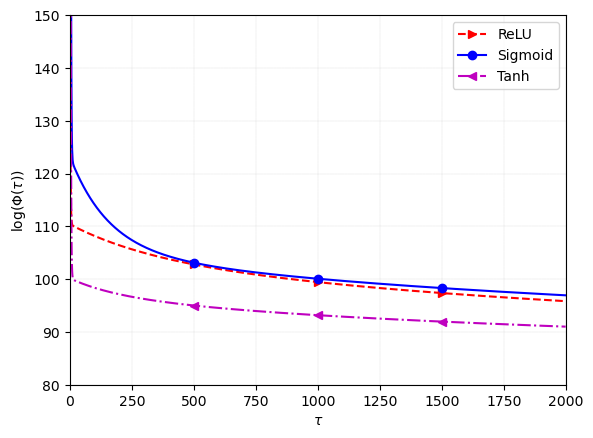

In [118]:
plt.figure(2)
plt.plot(range(epochs), loss_plot3000ReLU,'r--',marker='>',markevery=500)
plt.plot(range(epochs), loss_plot3000,'b-',marker='o',markevery=500)
plt.plot(range(epochs), loss_plot3000tanh,'m-.',marker='<',markevery=500)
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\log(\Phi(\tau))$')
plt.legend(['ReLU','Sigmoid','Tanh'])
plt.axis([0,2000,80,150])
plt.savefig('code_DEM_comp.pdf') 
plt.savefig('code_DEM_comp.eps') 
plt.grid(color='k', linestyle='--', linewidth=.05)